# Set-up

In [1]:
import os
import pandas as pd
import numpy as np
from mygene import MyGeneInfo
import re
import requests
import pyranges as pr

from tqdm.auto import tqdm

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TODO
- [ ] Add a flag that indicates whether we used the guide coordinates as intended target coordinates
- [ ] Add a flag for multimappers
- [ ] Add a flag for missing mapping

# GTF gene coordinates

In [2]:
# Example — change this to the full URL of the GTF file
url = "https://api.data.igvf.org/reference-files/IGVFFI9573KOZR/@@download/IGVFFI9573KOZR.gtf.gz"
out_path = "/cellar/users/aklie/data/datasets/tf_perturb_seq/ref/IGVFFI9573KOZR.gtf.gz"

# Stream download to avoid memory issues, only if doesn't already exist
if not os.path.exists(out_path):
    print("Downloading", url)
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
elif os.path.getsize(out_path) > 0:
    print("File already exists and is non-empty, skipping download.")
else:
    print("File exists but is empty, re-downloading.")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

print("Downloaded to", out_path)

File already exists and is non-empty, skipping download.
Downloaded to /cellar/users/aklie/data/datasets/tf_perturb_seq/ref/IGVFFI9573KOZR.gtf.gz


In [3]:
# Filter to just gene-level annotations
gtf_pr = pr.read_gtf(out_path)
genes_pr = gtf_pr[(gtf_pr.Feature == "gene") & (gtf_pr.gene_type.isin(["protein_coding", "lncRNA"]))]
genes_pr

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_support_level,havana_transcript,exon_number,exon_id,hgnc_id,havana_gene,ont,protein_id,ccdsid,artif_dupl
0,chr1,HAVANA,gene,11868,14409,.,+,.,ENSG00000290825.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,gene,29553,31109,.,+,.,ENSG00000243485.5,lncRNA,...,NaN,NaN,NaN,NaN,HGNC:52482,OTTHUMG00000000959.2,NaN,NaN,NaN,NaN
2,chr1,HAVANA,gene,57597,64116,.,+,.,ENSG00000290826.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,HAVANA,gene,65418,71585,.,+,.,ENSG00000186092.7,protein_coding,...,NaN,NaN,NaN,NaN,HGNC:14825,OTTHUMG00000001094.4,NaN,NaN,NaN,NaN
4,chr1,HAVANA,gene,160445,161525,.,+,.,ENSG00000241599.1,lncRNA,...,NaN,NaN,NaN,NaN,NaN,OTTHUMG00000002525.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41891,chrY,HAVANA,gene,25030900,25062548,.,-,.,ENSG00000185894.8,protein_coding,...,NaN,NaN,NaN,NaN,HGNC:18225,OTTHUMG00000045199.3,NaN,NaN,NaN,NaN
41892,chrY,HAVANA,gene,25063082,25099892,.,-,.,ENSG00000228296.1,lncRNA,...,NaN,NaN,NaN,NaN,HGNC:31892,OTTHUMG00000045200.1,NaN,NaN,NaN,NaN
41893,chrY,HAVANA,gene,25182276,25213389,.,-,.,ENSG00000223641.2,lncRNA,...,NaN,NaN,NaN,NaN,HGNC:31890,OTTHUMG00000045207.2,NaN,NaN,NaN,NaN
41894,chrY,HAVANA,gene,25378299,25394719,.,-,.,ENSG00000228786.5,lncRNA,...,NaN,NaN,NaN,NaN,HGNC:51709,OTTHUMG00000045201.1,NaN,NaN,NaN,NaN


In [4]:
# --- Define promoter coordinates (2kb upstream of TSS) ---
genes_df = genes_pr.df.copy()

# Compute start and end carefully depending on strand
promoters_df = pd.DataFrame({
    "Chromosome": genes_df["Chromosome"],
    "Strand": genes_df["Strand"],
    "gene_id": genes_df["gene_id"],
    "gene_name": genes_df["gene_name"],
})

# Compute Start and End for promoters
promoters_df["Start"] = promoters_df.apply(
    lambda x: max(0, genes_df.loc[x.name, "Start"] - 2000)
    if x.Strand == "+"
    else genes_df.loc[x.name, "End"],
    axis=1,
)
promoters_df["End"] = promoters_df.apply(
    lambda x: genes_df.loc[x.name, "Start"]
    if x.Strand == "+"
    else genes_df.loc[x.name, "End"] + 2000,
    axis=1,
)

# Convert to integers
promoters_df[["Start", "End"]] = promoters_df[["Start", "End"]].astype(int)

# Check that it looks correct
promoters_pr = pr.PyRanges(promoters_df)
promoters_pr

,Chromosome,Strand,gene_id,gene_name,Start,End
0,chr1,+,ENSG00000290825.1,DDX11L2,9868,11868
1,chr1,+,ENSG00000243485.5,MIR1302-2HG,27553,29553
2,chr1,+,ENSG00000290826.1,ENSG00000290826,55597,57597
3,chr1,+,ENSG00000186092.7,OR4F5,63418,65418
4,chr1,+,ENSG00000241599.1,ENSG00000241599,158445,160445
...,...,...,...,...,...,...
41891,chrY,-,ENSG00000185894.8,BPY2C,25062548,25064548
41892,chrY,-,ENSG00000228296.1,TTTY4C,25099892,25101892
41893,chrY,-,ENSG00000223641.2,TTTY17C,25213389,25215389
41894,chrY,-,ENSG00000228786.5,SEPTIN14P23,25394719,25396719


# Load reference metadata

## Reference TF guides

In [5]:
path_ref_tf_metadata = "/cellar/users/aklie/data/datasets/tf_perturb_seq/ref/target_genes.tsv"
spacer_cols = ['Set A, Photospacer 1', 'Set A, Photospacer 2', 'Set B, Photospacer 3', 'Set B, Photospacer 4', 'Set C, Photospacer 5', 'Set C, Photospacer 6']
ref_tf = pd.read_csv(path_ref_tf_metadata, sep="\t")
ref_tf["Gene"] = ref_tf["Gene"].ffill()
for col in spacer_cols:
    ref_tf[col] = ref_tf[col].str.upper()

# Define mapping between sets, promoter columns, and photospacer columns
set_map = {
    "A": ("Set A, promoter ID", ["Set A, Photospacer 1", "Set A, Photospacer 2"]),
    "B": ("Set B, promoter ID", ["Set B, Photospacer 3", "Set B, Photospacer 4"]),
    "C": ("Set C, promoter ID", ["Set C, Photospacer 5", "Set C, Photospacer 6"]),
}

# Collect rows
rows = []
for _, row in ref_tf.iterrows():
    gene = row["Gene"]
    for set_name, (prom_col, spacer_cols) in set_map.items():
        promoter_id = row[prom_col]
        for spacer_col in spacer_cols:
            spacer_seq = row[spacer_col]
            if pd.notna(spacer_seq):
                # Extract photospacer number from column name
                match = re.search(r"Photospacer (\d+)", spacer_col)
                spacer_num = int(match.group(1)) if match else None
                rows.append({
                    "Gene": gene,
                    "promoter_ID": promoter_id,
                    "Set": set_name,
                    "Photospacer": spacer_seq,
                    "Photospacer_number": spacer_num,
                })

# Create the long df
ref_tf_long = pd.DataFrame(rows)[["Gene", "promoter_ID", "Set", "Photospacer", "Photospacer_number"]]

# Make a unique guide ID based on promoter_ID#Set_{Set}#Photospacer_{Photospacer_number}
ref_tf_long["guide_id"] = ref_tf_long.apply(lambda x: f"{x['promoter_ID']}#Set_{x['Set']}#Photospacer_{x['Photospacer_number']}", axis=1)
ref_tf_long.head()

,Gene,promoter_ID,Set,Photospacer,Photospacer_number,guide_id
0,AATF,AATF_-_35306286.23-P1P2,A,GAGTGGCCGGTCCAGAGCTG,1,AATF_-_35306286.23-P1P2#Set_A#Photospacer_1
1,AATF,AATF_-_35306286.23-P1P2,A,GGGATCAAGGCGAGAGGATC,2,AATF_-_35306286.23-P1P2#Set_A#Photospacer_2
2,AATF,AATF_-_35306351.23-P1P2,B,GAAGGCGAGAGGATCCGGCA,3,AATF_-_35306351.23-P1P2#Set_B#Photospacer_3
3,AATF,AATF_-_35306351.23-P1P2,B,GGGAATCGGATCAAGGCGAG,4,AATF_-_35306351.23-P1P2#Set_B#Photospacer_4
4,AATF,AATF_-_35306333.23-P1P2,C,GGAGTCGGGGAATCGGATCA,5,AATF_-_35306333.23-P1P2#Set_C#Photospacer_5


## Reference positive controls

In [6]:
def clean_gene_and_make_guide(x):
    x = x.strip()
    
    # --- Remove parentheses in gene names like "CD29 (ITGB1)" ---
    base = re.sub(r"\s*\([^)]*\)", "", x).strip()
    
    # --- Handle sgRNA naming ---
    if "sgRNA" in x:
        base_gene = x.split("sgRNA")[0].strip()
        suffix = x.split("sgRNA")[-1].strip().lower()
        if suffix == "main":
            guide_id = f"{base_gene}#A"
        elif suffix in ["a", "b", "c"]:
            guide_id = f"{base_gene}#{suffix.upper()}"
        else:
            guide_id = f"{base_gene}#A"
        return pd.Series([base_gene, guide_id])
    
    # --- Handle "strong"/"weak" ---
    if re.search(r"\bstrong\b|\bweak\b", x, re.IGNORECASE):
        base_gene = re.sub(r"\s*(strong|weak)\s*", "", base, flags=re.IGNORECASE)
        strength = "strong" if "strong" in x.lower() else "weak"
        guide_id = f"{base_gene}#{strength}"
        return pd.Series([base_gene, guide_id])
    
    # --- Default case: use cleaned base name ---
    return pd.Series([base, f"{base}#A"])

# Load reference 
path_ref_pc_metadata = "/cellar/users/aklie/data/datasets/tf_perturb_seq/ref/positive_controls.tsv"
ref_pcs = pd.read_csv(path_ref_pc_metadata, sep="\t")
ref_pcs = ref_pcs.rename(columns={"Photospacer (represent 10 times)": "Photospacer"})
ref_pcs[["Gene", "guide_id"]] = ref_pcs["Gene"].apply(clean_gene_and_make_guide)
ref_pcs.head()

,Gene,Photospacer,Reference,guide_id
0,CD81,GGAGAGCGAGCGCGCAACGG,"Horlbeck et al. 2016 ""Compact and highly activ...",CD81#strong
1,CD81,GGAGAGCCAGCGCGCAACGG,"Jost et al. 2020 ""Titrating gene expression us...",CD81#weak
2,CD151,GCCGGACTCGGACGCGTGGT,"Horlbeck et al. 2016 ""Compact and highly activ...",CD151#strong
3,CD151,GCCGCTCGGCCGAGCTGTCG,"Horlbeck et al. 2016 ""Compact and highly activ...",CD151#weak
4,CD55,GCTGCGACTCGGCGGAGTCC,"Horlbeck et al. 2016 ""Compact and highly activ...",CD55#strong


## Reference non-targeting controls

In [7]:
path_ref_nt_metadata = "/cellar/users/aklie/data/datasets/tf_perturb_seq/ref/non_targeting.tsv"
ref_nt = pd.read_csv(path_ref_nt_metadata, sep="\t")
ref_nt = ref_nt.rename(columns={"Unnamed: 0": "guide_id", "Photospacer (same for all 3 sets)": "Photospacer"})
ref_nt["Gene"] = "non-targeting"
ref_nt.head()

,guide_id,Photospacer,Gene
0,non-targeting_00642,GGAGTTAAGGCCTCGTCTAG,non-targeting
1,non-targeting_00718,GTCCCAGGCTCTCCACTATG,non-targeting
2,non-targeting_03631,GGACGCGTCTGCAAGAACGT,non-targeting
3,non-targeting_03705,GGGCATGGACCCGCGGCACG,non-targeting
4,non-targeting_01469,GCGTCCGAGGTACTGAATAA,non-targeting


## Reference negative controls (targeting)

In [8]:
# ---------- 1. Base reference ----------
path_ref_nc_metadata = "/cellar/users/aklie/data/datasets/tf_perturb_seq/ref/negative_controls.tsv"
ref_nc = pd.read_csv(path_ref_nc_metadata, sep="\t")

# Standardize case
spacer_cols = [c for c in ref_nc.columns if c.startswith("Photospacer")]
for col in spacer_cols:
    ref_nc[col] = ref_nc[col].str.upper()

# Melt to long format
ref_nc_long = ref_nc.melt(
    id_vars=["Gene"],
    value_vars=spacer_cols,
    var_name="Photospacer_label",
    value_name="Photospacer"
)
ref_nc_long["Photospacer_number"] = ref_nc_long["Photospacer_label"].str.extract(r"(\d+)").astype(int)
ref_nc_long["guide_id"] = ref_nc_long.apply(
    lambda x: f"{x['Gene']}#Set_A#Photospacer_{x['Photospacer_number']}", axis=1
)
ref_nc_long = ref_nc_long[["Gene", "Photospacer", "Photospacer_number", "guide_id"]]

# ---------- 2. Single-protospacer negatives ----------
path_simple_nc = "/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_10_05/2025_10_05_negative_controls.tsv"
ref_nc_single = pd.read_csv(path_simple_nc, sep="\t")

# Normalize column names and create unified structure
ref_nc_single = (
    ref_nc_single.rename(columns={"gene": "Gene", "protospacer_A": "Photospacer"})
    .assign(Photospacer_number=1)
)
ref_nc_single["Photospacer"] = ref_nc_single["Photospacer"].str.upper()
ref_nc_single["guide_id"] = ref_nc_single.apply(
    lambda x: f"{x['Gene']}#Set_A#Photospacer_{x['Photospacer_number']}", axis=1
)
ref_nc_single = ref_nc_single[["Gene", "Photospacer", "Photospacer_number", "guide_id"]]

# ---------- 3. Multi-set negatives ----------
path_more_nc = "/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_10_05/2025_10_05_more_negative_controls.tsv"
ref_nc_multi = pd.read_csv(path_more_nc, sep="\t")

# Identify photospacer columns automatically
photospacer_cols = [c for c in ref_nc_multi.columns if "Photospacer" in c]

# Melt to long format
ref_nc_multi_long = ref_nc_multi.melt(
    id_vars=["Label"], value_vars=photospacer_cols,
    var_name="Photospacer_label", value_name="Photospacer"
)
ref_nc_multi_long["Gene"] = ref_nc_multi_long["Label"]
ref_nc_multi_long["Photospacer"] = ref_nc_multi_long["Photospacer"].str.upper()

# Extract number and set info
ref_nc_multi_long["Photospacer_number"] = ref_nc_multi_long["Photospacer_label"].str.extract(r"(\d+)").astype(int)
ref_nc_multi_long["Set"] = ref_nc_multi_long["Photospacer_label"].str.extract(r"(Set [A-Z])")

# Create guide_id harmonized with the same pattern
ref_nc_multi_long["guide_id"] = ref_nc_multi_long.apply(
    lambda x: f"{x['Gene']}#{x['Set'].replace(' ', '_')}#Photospacer_{x['Photospacer_number']}", axis=1
)

ref_nc_multi_long = ref_nc_multi_long[["Gene", "Photospacer", "Photospacer_number", "guide_id"]]

# ---------- 4. Concatenate & finalize ----------
ref_nc_all = pd.concat([ref_nc_long, ref_nc_single, ref_nc_multi_long], ignore_index=True)
ref_nc_all = ref_nc_all.drop_duplicates().sort_values(["Gene", "Photospacer_number"]).reset_index(drop=True)

ref_nc_all.head()

,Gene,Photospacer,Photospacer_number,guide_id
0,OR10A2,GTTCCTGTAGCTATAAGTGT,1,OR10A2#Set_A#Photospacer_1
1,OR10A3,GTTCCTCCTGAACCTATCTG,1,OR10A3#Set_A#Photospacer_1
2,OR10A4,GGCCTGAAGCTCAGTGGACA,1,OR10A4#Set_A#Photospacer_1
3,OR10A5,GCTGGAGAGAGATTCTTGAT,1,OR10A5#Set_A#Photospacer_1
4,OR10A6,GGGTCACCAGATAAATAACC,1,OR10A6#Set_A#Photospacer_1


# Load guide metadata

In [9]:
path_guide_metadata = "/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/harmonized_guide_file_poolabcd_ensg.tsv"
guide_metadata = pd.read_csv(path_guide_metadata, sep="\t")
guide_metadata["gene_name_id"] = guide_metadata["guide_id"].str.split("#").str[0]
guide_metadata["G#spacer"] = "G" + guide_metadata["spacer"].str.upper()
print(f"{len(guide_metadata)} total guides")
guide_metadata.head()

14172 total guides


,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,label,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer
0,AARS#C,CCGCCCTCGGAGAGCTCTG,False,positive_control,chrPC,0.0,0.0,NaN,NaN,ENSG00000090861,chrPC,0.0,0.0,positive_control,promoter,NaN,NaN,NaN,AARS,GCCGCCCTCGGAGAGCTCTG
1,AARS#chr16:70289419-70289437(-),CGGCGACCCTAGGAGAGGT,False,positive_control,chr16,70289419.0,70289437.0,-,NaN,ENSG00000090861,chr16,70289409.0,70289495.0,positive_control,promoter,NaN,NaN,NaN,AARS,GCGGCGACCCTAGGAGAGGT
2,AARS#chr16:70289477-70289495(-),TCTGCGGGAATAGGTGCAG,False,positive_control,chr16,70289477.0,70289495.0,-,NaN,ENSG00000090861,chr16,70289409.0,70289495.0,positive_control,promoter,NaN,NaN,NaN,AARS,GTCTGCGGGAATAGGTGCAG
3,B2M#chr15:44711560-44711578(-),GCGAGCACAGCTAAGGCCA,False,positive_control,chr15,44711560.0,44711578.0,-,NaN,ENSG00000273686,chr15,44711545.0,44711959.0,positive_control,promoter,NaN,NaN,NaN,B2M,GGCGAGCACAGCTAAGGCCA
4,CD151#chr11:833006-833024(+),CCGGACTCGGACGCGTGGT,False,positive_control,chr11,833006.0,833024.0,+,NaN,ENSG00000177697,chr11,832818.0,833060.0,positive_control,promoter,NaN,NaN,NaN,CD151,GCCGGACTCGGACGCGTGGT


In [10]:
guide_metadata[guide_metadata["guide_id"] == "OR8U8#chr11:56375720-56375738(+)"][["intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end"]]

,intended_target_name,intended_target_chr,intended_target_start,intended_target_end
601,ENSG00000262315,chr11,56375606.0,56375925.0


In [11]:
guide_metadata["type"].value_counts()

type
targeting           12934
negative_control      619
non_targeting         600
positive_control       19
Name: count, dtype: int64

# Adding `gene_name`

In [12]:
# Which intended_target_name don't start with ENSG?
missing_ens = guide_metadata[~guide_metadata["intended_target_name"].str.startswith("ENSG")]["intended_target_name"].unique()

# Get map for those that have it
has_ens = guide_metadata[guide_metadata["intended_target_name"].str.startswith("ENSG")]
ens_mp = has_ens.set_index("gene_name_id")["intended_target_name"].str.split("-").str[0].to_dict()

# Find mappings for missing ENSG
missing_ens_mp = []
for gene_name in missing_ens:
    print(f"Finding mapping for {gene_name}")
    if gene_name[:-1] in ens_mp:
        print(f"Found {ens_mp[gene_name[:-1]]} for {gene_name}")
        missing_ens_mp.append((gene_name, ens_mp[gene_name[:-1]]))
    else:
        missing_ens_mp.append((gene_name, None))

# Fill in missing ENSG mappings
for gene_name, ensg in missing_ens_mp:
    if ensg:
        print(f"Updating {gene_name} with {ensg}")
        guide_metadata.loc[guide_metadata["intended_target_name"] == gene_name, "intended_target_name"] = ensg

# Should only be NONTARGETING
guide_metadata[~guide_metadata["intended_target_name"].str.startswith("ENSG")]["intended_target_name"].unique()

Finding mapping for OR11H61
Found ENSG00000291779 for OR11H61
Finding mapping for OR11H65
Found ENSG00000291779 for OR11H65
Finding mapping for OR1N25
Found ENSG00000171501 for OR1N25
Finding mapping for OR2C31
Found ENSG00000196242 for OR2C31
Finding mapping for OR2C32
Found ENSG00000196242 for OR2C32
Finding mapping for OR2C33
Found ENSG00000196242 for OR2C33
Finding mapping for OR2C34
Found ENSG00000196242 for OR2C34
Finding mapping for OR2C35
Found ENSG00000196242 for OR2C35
Finding mapping for OR2C36
Found ENSG00000196242 for OR2C36
Finding mapping for OR2H11
Found ENSG00000204688 for OR2H11
Finding mapping for OR2W11
Found ENSG00000226463 for OR2W11
Finding mapping for OR2W12
Found ENSG00000226463 for OR2W12
Finding mapping for OR2W15
Found ENSG00000226463 for OR2W15
Finding mapping for OR56A42
Found ENSG00000183389 for OR56A42
Finding mapping for OR56A43
Found ENSG00000183389 for OR56A43
Finding mapping for OR56A44
Found ENSG00000183389 for OR56A44
Finding mapping for OR9Q11
Fou

array(['NONTARGETING'], dtype=object)

In [13]:
# Initialize MyGeneInfo
mg = MyGeneInfo()

In [14]:
# Map intended_target_name (Ensembl IDs) to gene names
out = mg.querymany(guide_metadata['intended_target_name'].tolist(), scopes='ensembl.gene', fields='symbol', species='human')
map_df = pd.DataFrame(out)[['query', 'symbol']].rename(columns={'query': 'intended_target_name', 'symbol': 'gene_name_mygene'})
guide_metadata = pd.concat([guide_metadata, map_df["gene_name_mygene"]], axis=1)
guide_metadata.head()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
2049 input query terms found dup hits:	[('ENSG00000090861', 3), ('ENSG00000177697', 2), ('ENSG00000110651', 2), ('ENSG00000205981', 3), ('E
606 input query terms found no hit:	['NONTARGETING', 'NONTARGETING', 'NONTARGETING', 'NONTARGETING', 'NONTARGETING', 'NONTARGETING', 'NO


,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,intended_target_start,intended_target_end,label,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene
0,AARS#C,CCGCCCTCGGAGAGCTCTG,False,positive_control,chrPC,0.0,0.0,NaN,NaN,ENSG00000090861,...,0.0,0.0,positive_control,promoter,NaN,NaN,NaN,AARS,GCCGCCCTCGGAGAGCTCTG,AARS1
1,AARS#chr16:70289419-70289437(-),CGGCGACCCTAGGAGAGGT,False,positive_control,chr16,70289419.0,70289437.0,-,NaN,ENSG00000090861,...,70289409.0,70289495.0,positive_control,promoter,NaN,NaN,NaN,AARS,GCGGCGACCCTAGGAGAGGT,AARS1
2,AARS#chr16:70289477-70289495(-),TCTGCGGGAATAGGTGCAG,False,positive_control,chr16,70289477.0,70289495.0,-,NaN,ENSG00000090861,...,70289409.0,70289495.0,positive_control,promoter,NaN,NaN,NaN,AARS,GTCTGCGGGAATAGGTGCAG,AARS1
3,B2M#chr15:44711560-44711578(-),GCGAGCACAGCTAAGGCCA,False,positive_control,chr15,44711560.0,44711578.0,-,NaN,ENSG00000273686,...,44711545.0,44711959.0,positive_control,promoter,NaN,NaN,NaN,B2M,GGCGAGCACAGCTAAGGCCA,B2M
4,CD151#chr11:833006-833024(+),CCGGACTCGGACGCGTGGT,False,positive_control,chr11,833006.0,833024.0,+,NaN,ENSG00000177697,...,832818.0,833060.0,positive_control,promoter,NaN,NaN,NaN,CD151,GCCGGACTCGGACGCGTGGT,CD151


In [15]:
# How many mismatches between gene_name_id and mygene?
mismatched_gene_name = guide_metadata[(guide_metadata["gene_name_id"] != guide_metadata["gene_name_mygene"]) & 
                                     guide_metadata["gene_name_id"].notna() & 
                                     guide_metadata["gene_name_mygene"].notna()]
mismatched_gene_name[["guide_id", "intended_target_name", "gene_name_id", "gene_name_mygene"]]

,guide_id,intended_target_name,gene_name_id,gene_name_mygene
0,AARS#C,ENSG00000090861,AARS,AARS1
1,AARS#chr16:70289419-70289437(-),ENSG00000090861,AARS,AARS1
2,AARS#chr16:70289477-70289495(-),ENSG00000090861,AARS,AARS1
6,CD29#chr10:32958199-32958217(-),ENSG00000150093,CD29,ITGB1
14,NGFRAP1,ENSG00000166681,NGFRAP1,BEX3
...,...,...,...,...
14143,ZUFSP#chr6:116668529-116668547(+),ENSG00000153975,ZUFSP,ZUP1
14144,ZUFSP#chr6:116668590-116668608(-),ENSG00000153975,ZUFSP,ZUP1
14145,ZUFSP#chr6:116668613-116668631(-),ENSG00000153975,ZUFSP,ZUP1
14146,ZUFSP#chr6:116668711-116668729(+),ENSG00000153975,ZUFSP,ZUP1


In [16]:
guide_metadata[guide_metadata["guide_id"] == "NKX2-8#chr14:36582574-36582592(-)"]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,intended_target_start,intended_target_end,label,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene
6568,NKX2-8#chr14:36582574-36582592(-),ACCCTGGAGACCCGGACCT,True,targeting,chr14,36582574.0,36582592.0,-,NGG,ENSG00000136327,...,36582330.0,36582626.0,targeting,promoter,NaN,NaN,NaN,NKX2-8,GACCCTGGAGACCCGGACCT,NKX2-8


# Positive control metadata

In [17]:
# Grab the positive controls
pc_metadata = guide_metadata[guide_metadata["type"] == "positive_control"].copy()
print(f"{len(pc_metadata)} positive control guides")
pc_metadata

19 positive control guides


,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,intended_target_start,intended_target_end,label,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene
0,AARS#C,CCGCCCTCGGAGAGCTCTG,False,positive_control,chrPC,0.0,0.0,NaN,NaN,ENSG00000090861,...,0.0,0.0,positive_control,promoter,NaN,NaN,NaN,AARS,GCCGCCCTCGGAGAGCTCTG,AARS1
1,AARS#chr16:70289419-70289437(-),CGGCGACCCTAGGAGAGGT,False,positive_control,chr16,70289419.0,70289437.0,-,NaN,ENSG00000090861,...,70289409.0,70289495.0,positive_control,promoter,NaN,NaN,NaN,AARS,GCGGCGACCCTAGGAGAGGT,AARS1
2,AARS#chr16:70289477-70289495(-),TCTGCGGGAATAGGTGCAG,False,positive_control,chr16,70289477.0,70289495.0,-,NaN,ENSG00000090861,...,70289409.0,70289495.0,positive_control,promoter,NaN,NaN,NaN,AARS,GTCTGCGGGAATAGGTGCAG,AARS1
3,B2M#chr15:44711560-44711578(-),GCGAGCACAGCTAAGGCCA,False,positive_control,chr15,44711560.0,44711578.0,-,NaN,ENSG00000273686,...,44711545.0,44711959.0,positive_control,promoter,NaN,NaN,NaN,B2M,GGCGAGCACAGCTAAGGCCA,B2M
4,CD151#chr11:833006-833024(+),CCGGACTCGGACGCGTGGT,False,positive_control,chr11,833006.0,833024.0,+,NaN,ENSG00000177697,...,832818.0,833060.0,positive_control,promoter,NaN,NaN,NaN,CD151,GCCGGACTCGGACGCGTGGT,CD151
5,CD151#chr11:833042-833060(-),CCGCTCGGCCGAGCTGTCG,False,positive_control,chr11,833042.0,833060.0,-,NaN,ENSG00000177697,...,832818.0,833060.0,positive_control,promoter,NaN,NaN,NaN,CD151,GCCGCTCGGCCGAGCTGTCG,CD151
6,CD29#chr10:32958199-32958217(-),AGAGGCCCAGCGGGAGTCG,False,positive_control,chr10,32958199.0,32958217.0,-,NaN,ENSG00000150093,...,32957937.0,32958259.0,positive_control,promoter,NaN,NaN,NaN,CD29,GAGAGGCCCAGCGGGAGTCG,ITGB1
7,CD55#chr1:207321714-207321732(+),CTGCGACTCGGCGGAGTCC,False,positive_control,chr1,207321714.0,207321732.0,+,NaN,ENSG00000196352,...,207321700.0,207322397.0,positive_control,promoter,NaN,NaN,NaN,CD55,GCTGCGACTCGGCGGAGTCC,CD55
8,CD81#chr11:2377315-2377333(+),GAGAGCGAGCGCGCAACGG,False,positive_control,chr11,2377315.0,2377333.0,+,NaN,ENSG00000110651,...,2377312.0,2377521.0,positive_control,promoter,NaN,NaN,NaN,CD81,GGAGAGCGAGCGCGCAACGG,CD81
9,CD81#weak,GAGAGCCAGCGCGCAACGG,False,positive_control,chrPC,0.0,0.0,+,NaN,ENSG00000110651,...,0.0,0.0,positive_control,promoter,NaN,NaN,NaN,CD81,GGAGAGCCAGCGCGCAACGG,CD81


In [18]:
pc_metadata[pc_metadata.columns[:8]]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand
0,AARS#C,CCGCCCTCGGAGAGCTCTG,False,positive_control,chrPC,0.0,0.0,NaN
1,AARS#chr16:70289419-70289437(-),CGGCGACCCTAGGAGAGGT,False,positive_control,chr16,70289419.0,70289437.0,-
2,AARS#chr16:70289477-70289495(-),TCTGCGGGAATAGGTGCAG,False,positive_control,chr16,70289477.0,70289495.0,-
3,B2M#chr15:44711560-44711578(-),GCGAGCACAGCTAAGGCCA,False,positive_control,chr15,44711560.0,44711578.0,-
4,CD151#chr11:833006-833024(+),CCGGACTCGGACGCGTGGT,False,positive_control,chr11,833006.0,833024.0,+
5,CD151#chr11:833042-833060(-),CCGCTCGGCCGAGCTGTCG,False,positive_control,chr11,833042.0,833060.0,-
6,CD29#chr10:32958199-32958217(-),AGAGGCCCAGCGGGAGTCG,False,positive_control,chr10,32958199.0,32958217.0,-
7,CD55#chr1:207321714-207321732(+),CTGCGACTCGGCGGAGTCC,False,positive_control,chr1,207321714.0,207321732.0,+
8,CD81#chr11:2377315-2377333(+),GAGAGCGAGCGCGCAACGG,False,positive_control,chr11,2377315.0,2377333.0,+
9,CD81#weak,GAGAGCCAGCGCGCAACGG,False,positive_control,chrPC,0.0,0.0,+


In [19]:
pc_metadata["in_ref"] = pc_metadata["G#spacer"].isin(ref_pcs["Photospacer"])

In [20]:
pc_metadata[~pc_metadata["in_ref"]]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,intended_target_end,label,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene,in_ref


In [21]:
# Add reference guide_id
pc_metadata = pc_metadata.merge(ref_pcs[["Photospacer", "guide_id"]], left_on="G#spacer", right_on="Photospacer", how="left", suffixes=("", "_ref"))
pc_metadata

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene,in_ref,Photospacer,guide_id_ref
0,AARS#C,CCGCCCTCGGAGAGCTCTG,False,positive_control,chrPC,0.0,0.0,NaN,NaN,ENSG00000090861,...,promoter,NaN,NaN,NaN,AARS,GCCGCCCTCGGAGAGCTCTG,AARS1,True,GCCGCCCTCGGAGAGCTCTG,AARS#C
1,AARS#chr16:70289419-70289437(-),CGGCGACCCTAGGAGAGGT,False,positive_control,chr16,70289419.0,70289437.0,-,NaN,ENSG00000090861,...,promoter,NaN,NaN,NaN,AARS,GCGGCGACCCTAGGAGAGGT,AARS1,True,GCGGCGACCCTAGGAGAGGT,AARS#B
2,AARS#chr16:70289477-70289495(-),TCTGCGGGAATAGGTGCAG,False,positive_control,chr16,70289477.0,70289495.0,-,NaN,ENSG00000090861,...,promoter,NaN,NaN,NaN,AARS,GTCTGCGGGAATAGGTGCAG,AARS1,True,GTCTGCGGGAATAGGTGCAG,AARS#A
3,B2M#chr15:44711560-44711578(-),GCGAGCACAGCTAAGGCCA,False,positive_control,chr15,44711560.0,44711578.0,-,NaN,ENSG00000273686,...,promoter,NaN,NaN,NaN,B2M,GGCGAGCACAGCTAAGGCCA,B2M,True,GGCGAGCACAGCTAAGGCCA,B2M#A
4,CD151#chr11:833006-833024(+),CCGGACTCGGACGCGTGGT,False,positive_control,chr11,833006.0,833024.0,+,NaN,ENSG00000177697,...,promoter,NaN,NaN,NaN,CD151,GCCGGACTCGGACGCGTGGT,CD151,True,GCCGGACTCGGACGCGTGGT,CD151#strong
5,CD151#chr11:833042-833060(-),CCGCTCGGCCGAGCTGTCG,False,positive_control,chr11,833042.0,833060.0,-,NaN,ENSG00000177697,...,promoter,NaN,NaN,NaN,CD151,GCCGCTCGGCCGAGCTGTCG,CD151,True,GCCGCTCGGCCGAGCTGTCG,CD151#weak
6,CD29#chr10:32958199-32958217(-),AGAGGCCCAGCGGGAGTCG,False,positive_control,chr10,32958199.0,32958217.0,-,NaN,ENSG00000150093,...,promoter,NaN,NaN,NaN,CD29,GAGAGGCCCAGCGGGAGTCG,ITGB1,True,GAGAGGCCCAGCGGGAGTCG,CD29#A
7,CD55#chr1:207321714-207321732(+),CTGCGACTCGGCGGAGTCC,False,positive_control,chr1,207321714.0,207321732.0,+,NaN,ENSG00000196352,...,promoter,NaN,NaN,NaN,CD55,GCTGCGACTCGGCGGAGTCC,CD55,True,GCTGCGACTCGGCGGAGTCC,CD55#strong
8,CD81#chr11:2377315-2377333(+),GAGAGCGAGCGCGCAACGG,False,positive_control,chr11,2377315.0,2377333.0,+,NaN,ENSG00000110651,...,promoter,NaN,NaN,NaN,CD81,GGAGAGCGAGCGCGCAACGG,CD81,True,GGAGAGCGAGCGCGCAACGG,CD81#strong
9,CD81#weak,GAGAGCCAGCGCGCAACGG,False,positive_control,chrPC,0.0,0.0,+,NaN,ENSG00000110651,...,promoter,NaN,NaN,NaN,CD81,GGAGAGCCAGCGCGCAACGG,CD81,True,GGAGAGCCAGCGCGCAACGG,CD81#weak


In [22]:
# Write out as fasta file
path_out_pc_fasta = "/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/positive_control_guides.fasta"
with open(path_out_pc_fasta, "w") as f:
    for _, row in pc_metadata.iterrows():
        if row["guide_id"] == "CD81#weak":
            f.write(f">{row['guide_id']}\n{ref_pcs[ref_pcs['guide_id'] == 'CD81#strong']['Photospacer'].values[0][1:]}NGG\n")
        elif row["guide_id"] == "CD151#chr11:833042.0-833060.0(-)":
            f.write(f">{row['guide_id']}\n{ref_pcs[ref_pcs['guide_id'] == 'CD151#strong']['Photospacer'].values[0][1:]}NGG\n")
        else:
            f.write(f">{row['guide_id']}\n{row['spacer']}NGG\n")
print(f"Wrote positive control guides to {path_out_pc_fasta}")

Wrote positive control guides to /cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/positive_control_guides.fasta


In [23]:
blat_res = pd.read_csv("/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/2025_12_10_positive_control_BLAT_res_v2.tsv", sep="\t")
blat_res["tEnd_adj"] = np.where(blat_res["strand"] == "+", blat_res["tEnd"] - 3, blat_res["tEnd"])
blat_res["tStart_adj"] = np.where(blat_res["strand"] == "+", blat_res["tStart"], blat_res["tStart"] + 3) + 1
blat_res["tStrand"] = blat_res["strand"]
blat_res

,query,score,qStart,qEnd,qSize,identity,chrom,strand,tStart,tEnd,span,tEnd_adj,tStart_adj,tStrand
0,AARS#C,21,1,22,22,100.0%,chr16,-,70289393,70289415,22,70289415,70289397,-
1,AARS#chr16:70289419-70289437(-),21,1,22,22,100.0%,chr16,-,70289415,70289437,22,70289437,70289419,-
2,AARS#chr16:70289477-70289495(-),21,1,22,22,100.0%,chr16,-,70289473,70289495,22,70289495,70289477,-
3,B2M#chr15:44711560-44711578(-),21,1,22,22,100.0%,chr15,-,44711556,44711578,22,44711578,44711560,-
4,CD151#chr11:833006-833024(+),21,1,22,22,100.0%,chr11,+,833005,833027,22,833024,833006,+
5,CD151#chr11:833042-833060(-),21,1,22,22,100.0%,chr11,-,833038,833060,22,833060,833042,-
6,CD29#chr10:32958199-32958217(-),21,1,22,22,100.0%,chr10,-,32958195,32958217,22,32958217,32958199,-
7,CD55#chr1:207321714-207321732(+),21,1,22,22,100.0%,chr1,+,207321713,207321735,22,207321732,207321714,+
8,CD81#chr11:2377315-2377333(+),21,1,22,22,100.0%,chr11,+,2377314,2377336,22,2377333,2377315,+
9,CD81#weak,21,1,22,22,100.0%,chr11,+,2377314,2377336,22,2377333,2377315,+


<Axes: xlabel='count'>

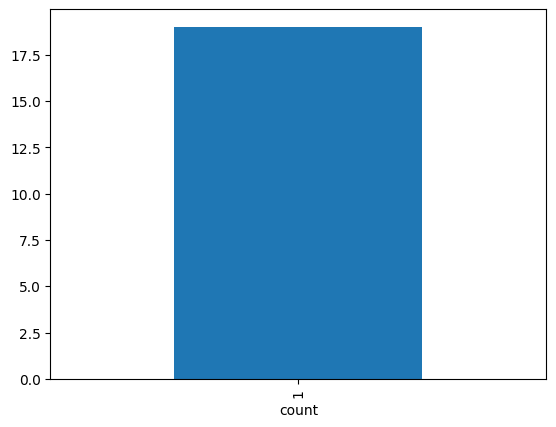

In [24]:
# Are there any query's with multiple alignments?
blat_res["query"].value_counts().value_counts().plot(kind="bar")

In [25]:
# Add in guide_chr, guide_start, guide_end from blat res to pc_metadata
pc_metadata = pc_metadata.merge(
    blat_res[["query", "chrom", "tStart_adj", "tEnd_adj", "tStrand"]],
    left_on="guide_id",
    right_on="query",
    how="left"
).rename(columns={
    "chrom": "guide_chr_blat",
    "tStart_adj": "guide_start_blat",
    "tEnd_adj": "guide_end_blat",
    "tStrand": "strand_blat"
}).drop(columns=["query"])
pc_metadata[["guide_id", "spacer", "gene_name_id", "intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end", "guide_start", "guide_end", "guide_chr_blat", "guide_start_blat", "guide_end_blat"]]

,guide_id,spacer,gene_name_id,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,guide_start,guide_end,guide_chr_blat,guide_start_blat,guide_end_blat
0,AARS#C,CCGCCCTCGGAGAGCTCTG,AARS,ENSG00000090861,chrPC,0.0,0.0,0.0,0.0,chr16,70289397,70289415
1,AARS#chr16:70289419-70289437(-),CGGCGACCCTAGGAGAGGT,AARS,ENSG00000090861,chr16,70289409.0,70289495.0,70289419.0,70289437.0,chr16,70289419,70289437
2,AARS#chr16:70289477-70289495(-),TCTGCGGGAATAGGTGCAG,AARS,ENSG00000090861,chr16,70289409.0,70289495.0,70289477.0,70289495.0,chr16,70289477,70289495
3,B2M#chr15:44711560-44711578(-),GCGAGCACAGCTAAGGCCA,B2M,ENSG00000273686,chr15,44711545.0,44711959.0,44711560.0,44711578.0,chr15,44711560,44711578
4,CD151#chr11:833006-833024(+),CCGGACTCGGACGCGTGGT,CD151,ENSG00000177697,chr11,832818.0,833060.0,833006.0,833024.0,chr11,833006,833024
5,CD151#chr11:833042-833060(-),CCGCTCGGCCGAGCTGTCG,CD151,ENSG00000177697,chr11,832818.0,833060.0,833042.0,833060.0,chr11,833042,833060
6,CD29#chr10:32958199-32958217(-),AGAGGCCCAGCGGGAGTCG,CD29,ENSG00000150093,chr10,32957937.0,32958259.0,32958199.0,32958217.0,chr10,32958199,32958217
7,CD55#chr1:207321714-207321732(+),CTGCGACTCGGCGGAGTCC,CD55,ENSG00000196352,chr1,207321700.0,207322397.0,207321714.0,207321732.0,chr1,207321714,207321732
8,CD81#chr11:2377315-2377333(+),GAGAGCGAGCGCGCAACGG,CD81,ENSG00000110651,chr11,2377312.0,2377521.0,2377315.0,2377333.0,chr11,2377315,2377333
9,CD81#weak,GAGAGCCAGCGCGCAACGG,CD81,ENSG00000110651,chrPC,0.0,0.0,0.0,0.0,chr11,2377315,2377333


In [26]:
# Create a dictionary mapping query to number_of_blat_alignments
query_to_blat_alignments = blat_res["query"].value_counts().to_dict()

# Add number_of_blat_alignments to pc_metadata
pc_metadata["number_of_blat_alignments"] = pc_metadata["guide_id"].map(query_to_blat_alignments).fillna(0)
pc_metadata["number_of_blat_alignments"].value_counts()

number_of_blat_alignments
1    19
Name: count, dtype: int64

In [27]:
# find all gene promoters withing 100kb of each guide mapping
dist = 10_000
pc_metadata_pr = pr.PyRanges(pc_metadata[["guide_id", "guide_chr_blat", "guide_start_blat", "guide_end_blat", "strand_blat"]].rename(columns={"guide_chr_blat": "Chromosome", "guide_start_blat": "Start", "guide_end_blat": "End", "strand_blat": "Strand"}))

# Find all gene promoters within 10kb of each guide mapping
overlaps_df = pc_metadata_pr.join(promoters_pr, how="left", slack=dist).df

# Get a list of all unique gene names for each guide_id in the overlaps, sorted by distance
# calculate the amount overlap between the guide and the promoter
overlaps_df["overlap"] = (overlaps_df["End"] - overlaps_df["Start"]).clip(lower=0)
overlaps_df["distance"] = np.where(overlaps_df["Strand"] == "+", overlaps_df["Start"] - overlaps_df["Start"], overlaps_df["End"] - overlaps_df["End"])
overlaps_df["distance"] = overlaps_df["distance"].abs()
unique_genes_per_guide = overlaps_df.groupby("guide_id")["gene_name"].apply(list).reset_index(name="unique_genes")
unique_genes_per_guide

,guide_id,unique_genes
0,AARS#C,"[DDX19B, AARS1, ENSG00000260537]"
1,AARS#chr16:70289419-70289437(-),"[DDX19B, AARS1, ENSG00000260537]"
2,AARS#chr16:70289477-70289495(-),"[DDX19B, AARS1, ENSG00000260537]"
3,B2M#chr15:44711560-44711578(-),"[B2M, PATL2]"
4,CD151#chr11:833006-833024(+),"[CRACR2B, CD151, ENSG00000255108, TSPAN4, POLR2L]"
5,CD151#chr11:833042-833060(-),"[CRACR2B, CD151, ENSG00000255108, TSPAN4, POLR2L]"
6,CD29#chr10:32958199-32958217(-),[ITGB1-DT]
7,CD55#chr1:207321714-207321732(+),[CD55]
8,CD81#chr11:2377315-2377333(+),"[CD81, ENSG00000290098, CD81-AS1]"
9,CD81#weak,"[CD81, ENSG00000290098, CD81-AS1]"


In [28]:
promoters_df[promoters_df["gene_name"] == "ITGB1"]

,Chromosome,Strand,gene_id,gene_name,Start,End
21358,chr10,-,ENSG00000150093.20,ITGB1,33005792,33007792


In [29]:
# Clean up
pc_metadata["targeting"] = True
pc_metadata["pam"] = "NGG"

# Fill in intended_target_chr, intended_target_start, intended_target_end from blat res if they are NaN
pc_metadata["using_guide_coords_for_intended_target"] = False
pc_metadata.loc[pc_metadata["intended_target_chr"] == "chrPC", "using_guide_coords_for_intended_target"] = True
pc_metadata.loc[pc_metadata["intended_target_chr"] == "chrPC", "intended_target_chr"] = pc_metadata.loc[pc_metadata["intended_target_chr"] == "chrPC", "guide_chr_blat"]
pc_metadata.loc[pc_metadata["intended_target_start"] == 0.0, "intended_target_start"] = pc_metadata.loc[pc_metadata["intended_target_start"] == 0.0, "guide_start_blat"]
pc_metadata.loc[pc_metadata["intended_target_end"] == 0.0, "intended_target_end"] = pc_metadata.loc[pc_metadata["intended_target_end"] == 0.0, "guide_end_blat"]

pc_metadata

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,gene_name_mygene,in_ref,Photospacer,guide_id_ref,guide_chr_blat,guide_start_blat,guide_end_blat,strand_blat,number_of_blat_alignments,using_guide_coords_for_intended_target
0,AARS#C,CCGCCCTCGGAGAGCTCTG,True,positive_control,chrPC,0.0,0.0,NaN,NGG,ENSG00000090861,...,AARS1,True,GCCGCCCTCGGAGAGCTCTG,AARS#C,chr16,70289397,70289415,-,1,True
1,AARS#chr16:70289419-70289437(-),CGGCGACCCTAGGAGAGGT,True,positive_control,chr16,70289419.0,70289437.0,-,NGG,ENSG00000090861,...,AARS1,True,GCGGCGACCCTAGGAGAGGT,AARS#B,chr16,70289419,70289437,-,1,False
2,AARS#chr16:70289477-70289495(-),TCTGCGGGAATAGGTGCAG,True,positive_control,chr16,70289477.0,70289495.0,-,NGG,ENSG00000090861,...,AARS1,True,GTCTGCGGGAATAGGTGCAG,AARS#A,chr16,70289477,70289495,-,1,False
3,B2M#chr15:44711560-44711578(-),GCGAGCACAGCTAAGGCCA,True,positive_control,chr15,44711560.0,44711578.0,-,NGG,ENSG00000273686,...,B2M,True,GGCGAGCACAGCTAAGGCCA,B2M#A,chr15,44711560,44711578,-,1,False
4,CD151#chr11:833006-833024(+),CCGGACTCGGACGCGTGGT,True,positive_control,chr11,833006.0,833024.0,+,NGG,ENSG00000177697,...,CD151,True,GCCGGACTCGGACGCGTGGT,CD151#strong,chr11,833006,833024,+,1,False
5,CD151#chr11:833042-833060(-),CCGCTCGGCCGAGCTGTCG,True,positive_control,chr11,833042.0,833060.0,-,NGG,ENSG00000177697,...,CD151,True,GCCGCTCGGCCGAGCTGTCG,CD151#weak,chr11,833042,833060,-,1,False
6,CD29#chr10:32958199-32958217(-),AGAGGCCCAGCGGGAGTCG,True,positive_control,chr10,32958199.0,32958217.0,-,NGG,ENSG00000150093,...,ITGB1,True,GAGAGGCCCAGCGGGAGTCG,CD29#A,chr10,32958199,32958217,-,1,False
7,CD55#chr1:207321714-207321732(+),CTGCGACTCGGCGGAGTCC,True,positive_control,chr1,207321714.0,207321732.0,+,NGG,ENSG00000196352,...,CD55,True,GCTGCGACTCGGCGGAGTCC,CD55#strong,chr1,207321714,207321732,+,1,False
8,CD81#chr11:2377315-2377333(+),GAGAGCGAGCGCGCAACGG,True,positive_control,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,...,CD81,True,GGAGAGCGAGCGCGCAACGG,CD81#strong,chr11,2377315,2377333,+,1,False
9,CD81#weak,GAGAGCCAGCGCGCAACGG,True,positive_control,chrPC,0.0,0.0,+,NGG,ENSG00000110651,...,CD81,True,GGAGAGCCAGCGCGCAACGG,CD81#weak,chr11,2377315,2377333,+,1,True


In [30]:
# Add a "new_guide_chr", "new_guide_start", "new_guide_end", "new_strand" based on the blat results
# If the the old guide coordinates are not NaN and don't match the blat coordinates, we will use those
# Otherwise, we will use the blat coordinates
# Also add a true/false column "blat_did_not_match_original_coords" to indicate if the blat coordinates did not match the old coordinates
pc_metadata["new_guide_chr"] = np.where(
    (pc_metadata["guide_start"] != 0.0) & (pc_metadata["guide_start"] != pc_metadata["guide_start_blat"]),
    pc_metadata["guide_chr"],
    pc_metadata["guide_chr_blat"]
)
pc_metadata["new_guide_start"] = np.where(
    (pc_metadata["guide_start"] != 0.0) & (pc_metadata["guide_start"] != pc_metadata["guide_start_blat"]),
    pc_metadata["guide_start"],
    pc_metadata["guide_start_blat"]
)
pc_metadata["new_guide_end"] = np.where(
    (pc_metadata["guide_start"] != 0.0) & (pc_metadata["guide_start"] != pc_metadata["guide_start_blat"]),
    pc_metadata["guide_end"],
    pc_metadata["guide_end_blat"]
)
pc_metadata["new_strand"] = np.where(
    (pc_metadata["guide_start"] != 0.0) & (pc_metadata["guide_start"] != pc_metadata["guide_start_blat"]),
    pc_metadata["strand"],
    pc_metadata["strand_blat"]
)
pc_metadata["blat_matched_original_coords"] = (pc_metadata["guide_start"] == pc_metadata["guide_start_blat"])
pc_metadata

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,guide_start_blat,guide_end_blat,strand_blat,number_of_blat_alignments,using_guide_coords_for_intended_target,new_guide_chr,new_guide_start,new_guide_end,new_strand,blat_matched_original_coords
0,AARS#C,CCGCCCTCGGAGAGCTCTG,True,positive_control,chrPC,0.0,0.0,NaN,NGG,ENSG00000090861,...,70289397,70289415,-,1,True,chr16,70289397.0,70289415.0,-,False
1,AARS#chr16:70289419-70289437(-),CGGCGACCCTAGGAGAGGT,True,positive_control,chr16,70289419.0,70289437.0,-,NGG,ENSG00000090861,...,70289419,70289437,-,1,False,chr16,70289419.0,70289437.0,-,True
2,AARS#chr16:70289477-70289495(-),TCTGCGGGAATAGGTGCAG,True,positive_control,chr16,70289477.0,70289495.0,-,NGG,ENSG00000090861,...,70289477,70289495,-,1,False,chr16,70289477.0,70289495.0,-,True
3,B2M#chr15:44711560-44711578(-),GCGAGCACAGCTAAGGCCA,True,positive_control,chr15,44711560.0,44711578.0,-,NGG,ENSG00000273686,...,44711560,44711578,-,1,False,chr15,44711560.0,44711578.0,-,True
4,CD151#chr11:833006-833024(+),CCGGACTCGGACGCGTGGT,True,positive_control,chr11,833006.0,833024.0,+,NGG,ENSG00000177697,...,833006,833024,+,1,False,chr11,833006.0,833024.0,+,True
5,CD151#chr11:833042-833060(-),CCGCTCGGCCGAGCTGTCG,True,positive_control,chr11,833042.0,833060.0,-,NGG,ENSG00000177697,...,833042,833060,-,1,False,chr11,833042.0,833060.0,-,True
6,CD29#chr10:32958199-32958217(-),AGAGGCCCAGCGGGAGTCG,True,positive_control,chr10,32958199.0,32958217.0,-,NGG,ENSG00000150093,...,32958199,32958217,-,1,False,chr10,32958199.0,32958217.0,-,True
7,CD55#chr1:207321714-207321732(+),CTGCGACTCGGCGGAGTCC,True,positive_control,chr1,207321714.0,207321732.0,+,NGG,ENSG00000196352,...,207321714,207321732,+,1,False,chr1,207321714.0,207321732.0,+,True
8,CD81#chr11:2377315-2377333(+),GAGAGCGAGCGCGCAACGG,True,positive_control,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,...,2377315,2377333,+,1,False,chr11,2377315.0,2377333.0,+,True
9,CD81#weak,GAGAGCCAGCGCGCAACGG,True,positive_control,chrPC,0.0,0.0,+,NGG,ENSG00000110651,...,2377315,2377333,+,1,True,chr11,2377315.0,2377333.0,+,False


In [31]:
# Create new to be "gene_name_id#guide_chr:guide_start-guide_end(guide_strand)", for those with non NaN blat results
pc_metadata["new_guide_id"] = pc_metadata.apply(
    lambda x: f"{x['gene_name_id']}#{x['new_guide_chr']}:{int(x['new_guide_start'])}-{int(x['new_guide_end'])}({x['new_strand']})"
    if pd.notna(x['new_guide_chr'])
    else x['guide_id'],
    axis=1
)

In [32]:
pc_metadata["blat_alignment_near_intended_target"] = True
pc_metadata["type"] = "positive control"

# Add genomic_element	putative_target_genes	reporter	imperfect
pc_clean_metadata = pc_metadata[["new_guide_id", "spacer", "targeting", "type", 
             "new_guide_chr", "new_guide_start", "new_guide_end", "new_strand", "pam", 
             "intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end", 
             "gene_name_id", "label", "genomic_element", "putative_target_genes", "reporter", "imperfect",
             "in_ref", "number_of_blat_alignments", "blat_alignment_near_intended_target", "blat_matched_original_coords", "using_guide_coords_for_intended_target"]].rename(columns={"new_guide_id": "guide_id", "new_guide_chr": "guide_chr", "new_guide_start": "guide_start", "new_guide_end": "guide_end", "new_strand": "strand", "gene_name_id": "gene_name", "in_ref": "in_ref_spreadsheet"})

print(pc_clean_metadata["number_of_blat_alignments"].value_counts()), 
print(pc_clean_metadata["blat_alignment_near_intended_target"].value_counts()), 
print(pc_clean_metadata["blat_matched_original_coords"].value_counts()),
print(pc_clean_metadata["using_guide_coords_for_intended_target"].value_counts()),
print(pc_clean_metadata["in_ref_spreadsheet"].value_counts())

number_of_blat_alignments
1    19
Name: count, dtype: int64
blat_alignment_near_intended_target
True    19
Name: count, dtype: int64
blat_matched_original_coords
True     13
False     6
Name: count, dtype: int64
using_guide_coords_for_intended_target
False    13
True      6
Name: count, dtype: int64
in_ref_spreadsheet
True    19
Name: count, dtype: int64


# Non-targeting control metadata

In [33]:
# Grab the non-targeting controls
nt_metadata = guide_metadata[guide_metadata["type"] == "non_targeting"]
nt_metadata

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,intended_target_start,intended_target_end,label,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene
638,non-targeting_00006,TATGGAGGGCTGGATCTGC,False,non_targeting,NaN,NaN,NaN,NaN,NaN,NONTARGETING,...,NaN,NaN,non_targeting,NaN,NaN,NaN,NaN,non-targeting_00006,GTATGGAGGGCTGGATCTGC,NaN
639,non-targeting_00010,TATCGGTCTGTACGGGTAG,False,non_targeting,NaN,NaN,NaN,NaN,NaN,NONTARGETING,...,NaN,NaN,non_targeting,NaN,NaN,NaN,NaN,non-targeting_00010,GTATCGGTCTGTACGGGTAG,NaN
640,non-targeting_00013,AGAGGTCGGATACGCTTCC,False,non_targeting,NaN,NaN,NaN,NaN,NaN,NONTARGETING,...,NaN,NaN,non_targeting,NaN,NaN,NaN,NaN,non-targeting_00013,GAGAGGTCGGATACGCTTCC,NaN
641,non-targeting_00018,GTCGCCGTAGGGTCCGCCA,False,non_targeting,NaN,NaN,NaN,NaN,NaN,NONTARGETING,...,NaN,NaN,non_targeting,NaN,NaN,NaN,NaN,non-targeting_00018,GGTCGCCGTAGGGTCCGCCA,NaN
642,non-targeting_00020,AGCCTAACGATCGGACCGA,False,non_targeting,NaN,NaN,NaN,NaN,NaN,NONTARGETING,...,NaN,NaN,non_targeting,NaN,NaN,NaN,NaN,non-targeting_00020,GAGCCTAACGATCGGACCGA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,non-targeting_03758,CAAAAGAAACGAATAACGC,False,non_targeting,NaN,NaN,NaN,NaN,NaN,NONTARGETING,...,NaN,NaN,non_targeting,NaN,NaN,NaN,NaN,non-targeting_03758,GCAAAAGAAACGAATAACGC,NaN
1234,non-targeting_03761,GCGGGTGAGAGCACCGTCA,False,non_targeting,NaN,NaN,NaN,NaN,NaN,NONTARGETING,...,NaN,NaN,non_targeting,NaN,NaN,NaN,NaN,non-targeting_03761,GGCGGGTGAGAGCACCGTCA,NaN
1235,non-targeting_03762,CTAGGTAGAGTCCTAGAGG,False,non_targeting,NaN,NaN,NaN,NaN,NaN,NONTARGETING,...,NaN,NaN,non_targeting,NaN,NaN,NaN,NaN,non-targeting_03762,GCTAGGTAGAGTCCTAGAGG,NaN
1236,non-targeting_03768,GCAGACCCCCTACGGAGGG,False,non_targeting,NaN,NaN,NaN,NaN,NaN,NONTARGETING,...,NaN,NaN,non_targeting,NaN,NaN,NaN,NaN,non-targeting_03768,GGCAGACCCCCTACGGAGGG,NaN


In [34]:
# check if non-targeting in ref
nt_metadata["in_ref"] = nt_metadata["G#spacer"].isin(ref_nt["Photospacer"])
nt_metadata["in_ref"].value_counts()

/tmp/ipykernel_1377720/2077716981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nt_metadata["in_ref"] = nt_metadata["G#spacer"].isin(ref_nt["Photospacer"])


in_ref
True    600
Name: count, dtype: int64

In [35]:
# 
len(nt_metadata)

600

In [36]:
# set guide_chr	guide_start	guide_end	strand	PAM to NaN
nt_metadata["type"] = "non-targeting"
nt_metadata["guide_chr"] = np.nan
nt_metadata["guide_start"] = np.nan
nt_metadata["guide_end"] = np.nan
nt_metadata["strand"] = np.nan
nt_metadata["pam"] = np.nan
nt_metadata["intended_target_name"] = np.nan
nt_metadata["intended_target_chr"] = np.nan
nt_metadata["intended_target_start"] = np.nan
nt_metadata["intended_target_end"] = np.nan
nt_metadata["gene_name"] = np.nan
nt_metadata["label"] = "non_targeting"

/tmp/ipykernel_1377720/834100427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nt_metadata["type"] = "non-targeting"
/tmp/ipykernel_1377720/834100427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nt_metadata["guide_chr"] = np.nan
/tmp/ipykernel_1377720/834100427.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [37]:
nt_clean_metadata = nt_metadata[["guide_id", "spacer", "targeting", "type", "guide_start", "guide_end", "guide_chr", "strand", "pam",
             "intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end",
             "gene_name", "label", "genomic_element", "putative_target_genes", "reporter", "imperfect", "in_ref"]].rename(columns={"in_ref": "in_ref_spreadsheet"})


nt_clean_metadata["number_of_blat_alignments"] = 0
nt_clean_metadata["blat_alignment_near_intended_target"] = False
nt_clean_metadata["blat_matched_original_coords"] = False
nt_clean_metadata["using_guide_coords_for_intended_target"] = False
nt_clean_metadata.head()

,guide_id,spacer,targeting,type,guide_start,guide_end,guide_chr,strand,pam,intended_target_name,...,label,genomic_element,putative_target_genes,reporter,imperfect,in_ref_spreadsheet,number_of_blat_alignments,blat_alignment_near_intended_target,blat_matched_original_coords,using_guide_coords_for_intended_target
638,non-targeting_00006,TATGGAGGGCTGGATCTGC,False,non-targeting,NaN,NaN,NaN,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0,False,False,False
639,non-targeting_00010,TATCGGTCTGTACGGGTAG,False,non-targeting,NaN,NaN,NaN,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0,False,False,False
640,non-targeting_00013,AGAGGTCGGATACGCTTCC,False,non-targeting,NaN,NaN,NaN,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0,False,False,False
641,non-targeting_00018,GTCGCCGTAGGGTCCGCCA,False,non-targeting,NaN,NaN,NaN,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0,False,False,False
642,non-targeting_00020,AGCCTAACGATCGGACCGA,False,non-targeting,NaN,NaN,NaN,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0,False,False,False


# Inspect targeting metadata

In [38]:
# Grab only the guides targeting targetings
targeting_metadata = guide_metadata[guide_metadata["label"].isin(["negative_control", "targeting"])]

# Check Photospacer column against all spacers in ref_targeting_long
targeting_metadata["in_tf_ref"] = targeting_metadata["G#spacer"].isin(ref_tf_long["Photospacer"])
targeting_metadata["in_nc_ref"] = targeting_metadata["G#spacer"].isin(ref_nc_all["Photospacer"])

# OR genes
targeting_metadata["is_OR_gene"] = targeting_metadata["gene_name_id"].str.startswith("OR")

# Check
targeting_metadata[targeting_metadata.columns[:8]]

/tmp/ipykernel_1377720/868831069.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeting_metadata["in_tf_ref"] = targeting_metadata["G#spacer"].isin(ref_tf_long["Photospacer"])
/tmp/ipykernel_1377720/868831069.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeting_metadata["in_nc_ref"] = targeting_metadata["G#spacer"].isin(ref_nc_all["Photospacer"])
/tmp/ipykernel_1377720/868831069.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand
19,OR10G4-1,GCTGTCACGAGGCTGGCGT,False,negative_control,NaN,NaN,NaN,NaN
20,OR10G4-2,GGCTGGACGCCCTCCTCTT,False,negative_control,NaN,NaN,NaN,NaN
21,OR10G4-3,GAGGATGAATGCTGTCACG,False,negative_control,NaN,NaN,NaN,NaN
22,OR10G4-4,TTGGTGTCCCCAAGCGGCA,False,negative_control,NaN,NaN,NaN,NaN
23,OR10G4-5,ATGAATGCTGTCACGAGGC,False,negative_control,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
14167,ZZZ3#chr1:77682544-77682562(+),ACCAAGAGGCACTCGCCCC,True,targeting,chr1,77682544.0,77682562.0,+
14168,ZZZ3#chr1:77682717-77682735(+),TCCACTAGACCCAACATGG,True,targeting,chr1,77682717.0,77682735.0,+
14169,ZZZ3#chr1:77683038-77683056(-),TGTGCGCGGGCGAAAGGGG,True,targeting,chr1,77683038.0,77683056.0,-
14170,ZZZ3#chr1:77683358-77683376(+),GCTGCAGGAAGCTCGATAG,True,targeting,chr1,77683358.0,77683376.0,+


In [39]:
targeting_metadata["in_nc_ref"].value_counts()

in_nc_ref
False    12955
True       598
Name: count, dtype: int64

In [40]:
targeting_metadata["in_tf_ref"].value_counts()

in_tf_ref
True     12934
False      619
Name: count, dtype: int64

In [41]:
# How many
targeting_metadata["in_nc_ref"].sum(), targeting_metadata["in_tf_ref"].sum()

(np.int64(598), np.int64(12934))

In [42]:
pd.crosstab(targeting_metadata["in_nc_ref"], targeting_metadata["is_OR_gene"])

is_OR_gene,False,True
in_nc_ref,,
False,12934,21
True,0,598


In [43]:
pd.crosstab(targeting_metadata["label"], targeting_metadata["is_OR_gene"])

is_OR_gene,False,True
label,,
negative_control,0,619
targeting,12934,0


# Negative control targets

In [44]:
nc_metadata = targeting_metadata[targeting_metadata["is_OR_gene"] == True]
nc_metadata["gene_name_id"] = nc_metadata["gene_name_id"].str.split("-").str[0]
len(nc_metadata)

/tmp/ipykernel_1377720/519638697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nc_metadata["gene_name_id"] = nc_metadata["gene_name_id"].str.split("-").str[0]


619

In [45]:
nc_metadata["in_tf_ref"].sum(), nc_metadata["in_nc_ref"].sum()

(np.int64(0), np.int64(598))

<Axes: xlabel='count'>

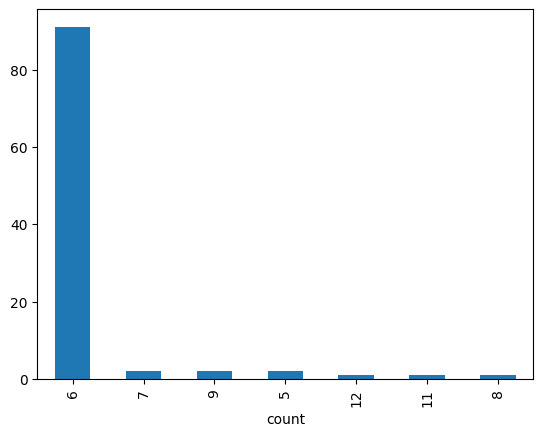

In [46]:
nc_metadata["gene_name_id"].value_counts().value_counts().plot(kind='bar')

In [47]:
nc_metadata[nc_metadata["in_nc_ref"]]["gene_name_id"].nunique()

100

In [48]:
nc_metadata[nc_metadata["in_nc_ref"]]["gene_name_id"].value_counts()

gene_name_id
OR10G4    6
OR10H2    6
OR10H5    6
OR10K1    6
OR10P1    6
         ..
OR9A2     6
ORAI1     6
OR9K2     6
OR2T5     5
OR51A2    5
Name: count, Length: 100, dtype: int64

In [49]:
nc_metadata[~nc_metadata["in_nc_ref"]]["gene_name_id"].value_counts()

gene_name_id
OR2C3     6
OR9Q1     5
OR2W1     3
OR56A4    3
OR11H6    2
OR1N2     1
OR2H1     1
Name: count, dtype: int64

In [50]:
nc_metadata["guide_start"].isna().sum()

np.int64(127)

In [51]:
nc_metadata[nc_metadata["guide_start"].isna()]["gene_name_id"].value_counts()

gene_name_id
OR10G4    6
OR1M1     6
OR2A1     6
OR2H2     6
OR2C3     6
OR2T29    6
OR4C3     6
OR4A5     6
OR2T33    6
OR8H3     6
OR8B3     6
OR7A10    6
OR4C12    6
OR4C45    6
OR5M1     6
OR5K2     6
OR51A4    6
OR9Q1     5
OR51A2    5
OR2T5     5
OR2W1     3
OR56A4    3
OR11H6    2
OR2H1     1
OR1N2     1
Name: count, dtype: int64

In [52]:
nc_metadata[nc_metadata["guide_start"].isna()]["in_nc_ref"].value_counts()

in_nc_ref
True     106
False     21
Name: count, dtype: int64

In [53]:
guide_metadata[guide_metadata["guide_id"] == "OR8U8#chr11:56375720-56375738(+)"][["intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end"]]

,intended_target_name,intended_target_chr,intended_target_start,intended_target_end
601,ENSG00000262315,chr11,56375606.0,56375925.0


In [54]:
# Write out as fasta file
path_out_nc_fasta = "/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/negative_control_guides.fasta"
with open(path_out_nc_fasta, "w") as f:
    for _, row in nc_metadata.iterrows():
        f.write(f">{row['guide_id']}\n{row['spacer']}NGG\n")
print(f"Wrote negative control guides to {path_out_nc_fasta}")

Wrote negative control guides to /cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/negative_control_guides.fasta


In [55]:
blat_res = pd.read_csv("/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/2025_12_10_negative_control_BLAT_res_v3.tsv", sep="\t")
blat_res["tEnd_adj"] = np.where(blat_res["strand"] == "+", blat_res["tEnd"] - 3, blat_res["tEnd"])
blat_res["tStart_adj"] = np.where(blat_res["strand"] == "+", blat_res["tStart"], blat_res["tStart"] + 3) + 1
blat_res["tStrand"] = blat_res["strand"]
blat_res["gene_name"] = blat_res["query"].str.split("#").str[0]
blat_res["gene_name"] = blat_res["gene_name"].str.split("-").str[0]
blat_res

,query,score,qStart,qEnd,qSize,identity,chrom,strand,tStart,tEnd,span,tEnd_adj,tStart_adj,tStrand,gene_name
0,OR10G4-1,21,1,22,22,100.0%,chr11,-,124015578,124015600,22,124015600,124015582,-,OR10G4
1,OR10G4-2,21,1,22,22,100.0%,chr11,+,124015632,124015654,22,124015651,124015633,+,OR10G4
2,OR10G4-3,21,1,22,22,100.0%,chr11,-,124015588,124015610,22,124015610,124015592,-,OR10G4
3,OR10G4-4,21,1,22,22,100.0%,chr11,+,124023258,124023280,22,124023277,124023259,+,OR10G4
4,OR10G4-4,21,1,22,22,100.0%,chr11,+,124015820,124015842,22,124015839,124015821,+,OR10G4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,ORAI1#chr12:121626540-121626558(+),21,1,22,22,100.0%,chr12,+,121626539,121626561,22,121626558,121626540,+,ORAI1
735,ORAI1#chr12:121626554-121626572(-),21,1,22,22,100.0%,chr12,-,121626550,121626572,22,121626572,121626554,-,ORAI1
736,ORAI1#chr12:121626557-121626575(-),21,1,22,22,100.0%,chr12,-,121626553,121626575,22,121626575,121626557,-,ORAI1
737,ORAI1#chr12:121626580-121626598(-),21,1,22,22,100.0%,chr12,-,121626576,121626598,22,121626598,121626580,-,ORAI1


<Axes: xlabel='count'>

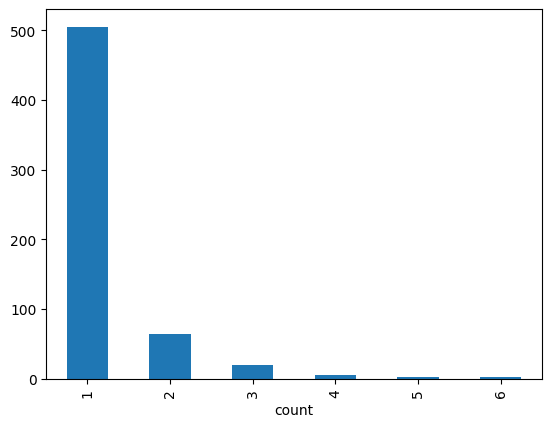

In [56]:
# how many query's with multiple alignments?
blat_res["query"].value_counts().value_counts().plot(kind="bar")

In [57]:
# How many that have 2 alignments are overlapping?
two_alignment_res = blat_res.groupby("query").filter(lambda x: len(x) == 2)
overlapping = []
for _, group in two_alignment_res.groupby("query"):
    pair_1 = (group.iloc[0]["tStart_adj"], group.iloc[0]["tEnd_adj"])
    pair_2 = (group.iloc[1]["tStart_adj"], group.iloc[1]["tEnd_adj"])
    if max(pair_1) > min(pair_2) and max(pair_2) > min(pair_1):
        overlapping.append(group.iloc[0]["query"])
len(overlapping)

0

In [58]:
three_alignment_res = blat_res.groupby("query").filter(lambda x: len(x) == 3)
len(three_alignment_res) // 3

20

In [59]:
# First calculate how far the hit is from the TSS of the gene_name based on the gtf, use -1 if on a different chromosome
distances_from_intended_target = []
for _, row in blat_res.iterrows():
    target_promoter = promoters_df[(promoters_df["gene_name"] == row["gene_name"]) & (promoters_df["Chromosome"] == row["chrom"])]
    if not target_promoter.empty:
        dist = min(
            abs(row["tStart_adj"] - target_promoter["Start"].values[0]),
            abs(row["tStart_adj"] - target_promoter["End"].values[0]),
            abs(row["tEnd_adj"] - target_promoter["Start"].values[0]),
            abs(row["tEnd_adj"] - target_promoter["End"].values[0])
        )
        distances_from_intended_target.append(dist)
    else:
        distances_from_intended_target.append(-1)
blat_res["distance_from_intended_target"] = distances_from_intended_target
blat_res

,query,score,qStart,qEnd,qSize,identity,chrom,strand,tStart,tEnd,span,tEnd_adj,tStart_adj,tStrand,gene_name,distance_from_intended_target
0,OR10G4-1,21,1,22,22,100.0%,chr11,-,124015578,124015600,22,124015600,124015582,-,OR10G4,2586
1,OR10G4-2,21,1,22,22,100.0%,chr11,+,124015632,124015654,22,124015651,124015633,+,OR10G4,2637
2,OR10G4-3,21,1,22,22,100.0%,chr11,-,124015588,124015610,22,124015610,124015592,-,OR10G4,2596
3,OR10G4-4,21,1,22,22,100.0%,chr11,+,124023258,124023280,22,124023277,124023259,+,OR10G4,10263
4,OR10G4-4,21,1,22,22,100.0%,chr11,+,124015820,124015842,22,124015839,124015821,+,OR10G4,2825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,ORAI1#chr12:121626540-121626558(+),21,1,22,22,100.0%,chr12,+,121626539,121626561,22,121626558,121626540,+,ORAI1,32
735,ORAI1#chr12:121626554-121626572(-),21,1,22,22,100.0%,chr12,-,121626550,121626572,22,121626572,121626554,-,ORAI1,46
736,ORAI1#chr12:121626557-121626575(-),21,1,22,22,100.0%,chr12,-,121626553,121626575,22,121626575,121626557,-,ORAI1,49
737,ORAI1#chr12:121626580-121626598(-),21,1,22,22,100.0%,chr12,-,121626576,121626598,22,121626598,121626580,-,ORAI1,72


In [60]:
# find all gene promoters withing 100kb of each guide mapping
dist = 50_000
blat_res_pr = pr.PyRanges(blat_res[["query", "chrom", "tStart_adj", "tEnd_adj", "tStrand", "score", "gene_name", "distance_from_intended_target"]].rename(columns={"chrom": "Chromosome", "tStart_adj": "Start", "tEnd_adj": "End", "tStrand": "Strand"}))

# Find all gene promoters within 10kb of each guide mapping
overlaps_df = blat_res_pr.join(promoters_pr, how="left", slack=dist).df

# Pull out all those where gene_name matches gene_name_b in the overlap
overlap_matches = overlaps_df[overlaps_df["gene_name"] == overlaps_df["gene_name_b"]]
overlap_mismatches = overlaps_df[overlaps_df["gene_name"] != overlaps_df["gene_name_b"]]

In [61]:
# How many queries have 0 alignments where there is a match of gene_name and gene_name_b?
all_queries = set(overlaps_df["query"])
queries_wout_gene_matches = all_queries - set(overlap_matches["query"])
print(f"{len(queries_wout_gene_matches)} queries have 0 alignments where there is a match of gene_name and gene_name_b")

11 queries have 0 alignments where there is a match of gene_name and gene_name_b


In [62]:
# for matches, take the on and only one that is closest to the TSS of the gene_name
best_overlap_matches = overlap_matches.groupby("query").apply(lambda x: x.loc[x["distance_from_intended_target"].idxmin()])
best_overlap_matches["blat_alignment_near_intended_target"] = True
assert best_overlap_matches["query"].nunique() == len(best_overlap_matches)

# for mismatches first only grab the ones that didn't have any match, then take the one closest to the TSS of the gene_name if it is not -1, then take the highest scoring
best_overlap_mismatches = []
for query in queries_wout_gene_matches:
    mismatches = overlap_mismatches[overlap_mismatches["query"] == query]
    if not mismatches.empty:
        closest_to_tss = mismatches.loc[mismatches["distance_from_intended_target"].idxmin()]
        if closest_to_tss["distance_from_intended_target"] != -1:
            best_overlap_mismatches.append(closest_to_tss)
        else:
            best_overlap_mismatches.append(mismatches.loc[mismatches["score"].idxmax()])
best_overlap_mismatches = pd.DataFrame(best_overlap_mismatches)
best_overlap_mismatches["blat_alignment_near_intended_target"] = False
assert best_overlap_mismatches["query"].nunique() == len(best_overlap_mismatches)

# Concat the best matches and mismatches
best_overlaps = pd.concat([best_overlap_matches, best_overlap_mismatches], ignore_index=True)
assert best_overlaps["query"].nunique() == len(best_overlaps)
(best_overlaps["gene_name"] == best_overlaps["gene_name_b"]).value_counts()

/tmp/ipykernel_1377720/3653042622.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_overlap_matches = overlap_matches.groupby("query").apply(lambda x: x.loc[x["distance_from_intended_target"].idxmin()])


True     588
False     11
Name: count, dtype: int64

In [63]:
# Add in guide_chr, guide_start, guide_end from blat res to nc_metadata
nc_metadata = nc_metadata.merge(
    best_overlaps[["query", "Chromosome", "Start", "End", "Strand", "blat_alignment_near_intended_target"]],
    left_on="guide_id",
    right_on="query",
    how="left"
).rename(columns={
    "Chromosome": "guide_chr_blat",
    "Start": "guide_start_blat",
    "End": "guide_end_blat",
    "Strand": "strand_blat"
}).drop(columns=["query"])
nc_metadata[["guide_id", "spacer", "gene_name_id", "intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end", "guide_start", "guide_end", "guide_chr_blat", "guide_start_blat", "guide_end_blat"]]

,guide_id,spacer,gene_name_id,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,guide_start,guide_end,guide_chr_blat,guide_start_blat,guide_end_blat
0,OR10G4-1,GCTGTCACGAGGCTGGCGT,OR10G4,ENSG00000254737,NaN,NaN,NaN,NaN,NaN,chr11,124015582.0,124015600.0
1,OR10G4-2,GGCTGGACGCCCTCCTCTT,OR10G4,ENSG00000254737,NaN,NaN,NaN,NaN,NaN,chr11,124015633.0,124015651.0
2,OR10G4-3,GAGGATGAATGCTGTCACG,OR10G4,ENSG00000254737,NaN,NaN,NaN,NaN,NaN,chr11,124015592.0,124015610.0
3,OR10G4-4,TTGGTGTCCCCAAGCGGCA,OR10G4,ENSG00000254737,NaN,NaN,NaN,NaN,NaN,chr11,124015821.0,124015839.0
4,OR10G4-5,ATGAATGCTGTCACGAGGC,OR10G4,ENSG00000254737,NaN,NaN,NaN,NaN,NaN,chr11,124015588.0,124015606.0
...,...,...,...,...,...,...,...,...,...,...,...,...
614,ORAI1#chr12:121626540-121626558(+),TCTGGTCACTGCCGCCCGG,ORAI1,ENSG00000293604,chr12,121626500.0,121626801.0,121626540.0,121626558.0,chr12,121626540.0,121626558.0
615,ORAI1#chr12:121626554-121626572(-),GCTGGCAAAAGCCCCCGGG,ORAI1,ENSG00000293604,chr12,121626500.0,121626801.0,121626554.0,121626572.0,chr12,121626554.0,121626572.0
616,ORAI1#chr12:121626557-121626575(-),GCCGCTGGCAAAAGCCCCC,ORAI1,ENSG00000293604,chr12,121626500.0,121626801.0,121626557.0,121626575.0,chr12,121626557.0,121626575.0
617,ORAI1#chr12:121626580-121626598(-),GCCCCAGCACGCAGGCCCG,ORAI1,ENSG00000293604,chr12,121626500.0,121626801.0,121626580.0,121626598.0,chr12,121626580.0,121626598.0


In [64]:
# Create a dictionary mapping query to number_of_blat_alignments
query_to_blat_alignments = blat_res["query"].value_counts().to_dict()

# Add number_of_blat_alignments to nc_metadata
nc_metadata["number_of_blat_alignments"] = nc_metadata["guide_id"].map(query_to_blat_alignments).fillna(0)
nc_metadata["number_of_blat_alignments"].value_counts()

number_of_blat_alignments
1.0    505
2.0     64
3.0     20
0.0     20
4.0      6
5.0      2
6.0      2
Name: count, dtype: int64

In [65]:
print(f"Num missing guide_start_blat: {nc_metadata['guide_start_blat'].isna().sum()}")
nc_metadata[nc_metadata["guide_start_blat"].isna()]["gene_name_id"].value_counts()

Num missing guide_start_blat: 20


gene_name_id
OR2C3     6
OR9Q1     5
OR56A4    3
OR2W1     2
OR11H6    2
OR2H1     1
OR51E2    1
Name: count, dtype: int64

In [66]:
nc_metadata[nc_metadata["guide_start_blat"].isna()]["in_nc_ref"].value_counts()

in_nc_ref
False    19
True      1
Name: count, dtype: int64

In [67]:
# How many of those that already had coordinates match the blat coordinates
nc_metadata_had_coords = nc_metadata[~nc_metadata["guide_start"].isna()]
nc_metadata_had_coords[nc_metadata_had_coords["guide_start"] == nc_metadata_had_coords["guide_start_blat"]]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,gene_name_mygene,in_tf_ref,in_nc_ref,is_OR_gene,guide_chr_blat,guide_start_blat,guide_end_blat,strand_blat,blat_alignment_near_intended_target,number_of_blat_alignments
6,OR10H2#chr19:15728014-15728032(+),TCCTCTCTTCCCCAACTAG,False,negative_control,chr19,15728014.0,15728032.0,+,NaN,ENSG00000171942,...,OR10H2,False,True,True,chr19,15728014.0,15728032.0,+,True,1.0
7,OR10H2#chr19:15728018-15728036(-),ACCCCTAGTTGGGGAAGAG,False,negative_control,chr19,15728018.0,15728036.0,-,NaN,ENSG00000171942,...,OR10H2,False,True,True,chr19,15728018.0,15728036.0,-,True,1.0
8,OR10H2#chr19:15728027-15728045(-),ATGACGGCCACCCCTAGTT,False,negative_control,chr19,15728027.0,15728045.0,-,NaN,ENSG00000171942,...,OR10H2,False,True,True,chr19,15728027.0,15728045.0,-,True,1.0
9,OR10H2#chr19:15728031-15728049(+),AGGGGTGGCCGTCATGCTG,False,negative_control,chr19,15728031.0,15728049.0,+,NaN,ENSG00000171942,...,OR10H2,False,True,True,chr19,15728031.0,15728049.0,+,True,1.0
10,OR10H2#chr19:15728232-15728250(-),GGAGACTGAGAGGACGCAC,False,negative_control,chr19,15728232.0,15728250.0,-,NaN,ENSG00000171942,...,OR10H2,False,True,True,chr19,15728232.0,15728250.0,-,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,ORAI1#chr12:121626540-121626558(+),TCTGGTCACTGCCGCCCGG,False,negative_control,chr12,121626540.0,121626558.0,+,NaN,ENSG00000293604,...,ORAI1,False,True,True,chr12,121626540.0,121626558.0,+,True,1.0
615,ORAI1#chr12:121626554-121626572(-),GCTGGCAAAAGCCCCCGGG,False,negative_control,chr12,121626554.0,121626572.0,-,NaN,ENSG00000293604,...,ORAI1,False,True,True,chr12,121626554.0,121626572.0,-,True,1.0
616,ORAI1#chr12:121626557-121626575(-),GCCGCTGGCAAAAGCCCCC,False,negative_control,chr12,121626557.0,121626575.0,-,NaN,ENSG00000293604,...,ORAI1,False,True,True,chr12,121626557.0,121626575.0,-,True,1.0
617,ORAI1#chr12:121626580-121626598(-),GCCCCAGCACGCAGGCCCG,False,negative_control,chr12,121626580.0,121626598.0,-,NaN,ENSG00000293604,...,ORAI1,False,True,True,chr12,121626580.0,121626598.0,-,True,1.0


In [68]:
# How many of those that already had coordinates don't match the blat coordinates
nc_metadata_had_coords[nc_metadata_had_coords["guide_start"] != nc_metadata_had_coords["guide_start_blat"]]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,gene_name_mygene,in_tf_ref,in_nc_ref,is_OR_gene,guide_chr_blat,guide_start_blat,guide_end_blat,strand_blat,blat_alignment_near_intended_target,number_of_blat_alignments
339,OR51E2#chr11:4697804-4697822(-),GTGAGTTAGCACCACCACC,False,negative_control,chr11,4697804.0,4697822.0,-,NaN,ENSG00000167332,...,OR51E2,False,True,True,NaN,NaN,NaN,NaN,NaN,0.0


In [69]:
nc_metadata[~nc_metadata["intended_target_name"].str.startswith("ENSG")]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,gene_name_mygene,in_tf_ref,in_nc_ref,is_OR_gene,guide_chr_blat,guide_start_blat,guide_end_blat,strand_blat,blat_alignment_near_intended_target,number_of_blat_alignments


In [70]:
# Add a "new_guide_chr", "new_guide_start", "new_guide_end", "new_strand" based on the blat results
# If the the old guide coordinates are not NaN and don't match the blat coordinates, we will use those
# Otherwise, we will use the blat coordinates
# Also add a true/false column "blat_matched_original_coords" to indicate if the blat coordinates did match the old coordinates
nc_metadata["new_guide_chr"] = np.where(
    (nc_metadata["guide_start"].notna()) & (nc_metadata["guide_start"] != nc_metadata["guide_start_blat"]),
    nc_metadata["guide_chr"],
    nc_metadata["guide_chr_blat"]
)
nc_metadata["new_guide_start"] = np.where(
    (nc_metadata["guide_start"].notna()) & (nc_metadata["guide_start"] != nc_metadata["guide_start_blat"]),
    nc_metadata["guide_start"],
    nc_metadata["guide_start_blat"]
)
nc_metadata["new_guide_end"] = np.where(
    (nc_metadata["guide_start"].notna()) & (nc_metadata["guide_start"] != nc_metadata["guide_start_blat"]),
    nc_metadata["guide_end"],
    nc_metadata["guide_end_blat"]
)
nc_metadata["new_strand"] = np.where(
    (nc_metadata["guide_start"].notna()) & (nc_metadata["guide_start"] != nc_metadata["guide_start_blat"]),
    nc_metadata["strand"],
    nc_metadata["strand_blat"]
)
nc_metadata["blat_matched_original_coords"] = (nc_metadata["guide_start"] == nc_metadata["guide_start_blat"])
nc_metadata

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,guide_start_blat,guide_end_blat,strand_blat,blat_alignment_near_intended_target,number_of_blat_alignments,new_guide_chr,new_guide_start,new_guide_end,new_strand,blat_matched_original_coords
0,OR10G4-1,GCTGTCACGAGGCTGGCGT,False,negative_control,NaN,NaN,NaN,NaN,NaN,ENSG00000254737,...,124015582.0,124015600.0,-,True,1.0,chr11,124015582.0,124015600.0,-,False
1,OR10G4-2,GGCTGGACGCCCTCCTCTT,False,negative_control,NaN,NaN,NaN,NaN,NaN,ENSG00000254737,...,124015633.0,124015651.0,+,True,1.0,chr11,124015633.0,124015651.0,+,False
2,OR10G4-3,GAGGATGAATGCTGTCACG,False,negative_control,NaN,NaN,NaN,NaN,NaN,ENSG00000254737,...,124015592.0,124015610.0,-,True,1.0,chr11,124015592.0,124015610.0,-,False
3,OR10G4-4,TTGGTGTCCCCAAGCGGCA,False,negative_control,NaN,NaN,NaN,NaN,NaN,ENSG00000254737,...,124015821.0,124015839.0,+,True,3.0,chr11,124015821.0,124015839.0,+,False
4,OR10G4-5,ATGAATGCTGTCACGAGGC,False,negative_control,NaN,NaN,NaN,NaN,NaN,ENSG00000254737,...,124015588.0,124015606.0,-,True,2.0,chr11,124015588.0,124015606.0,-,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,ORAI1#chr12:121626540-121626558(+),TCTGGTCACTGCCGCCCGG,False,negative_control,chr12,121626540.0,121626558.0,+,NaN,ENSG00000293604,...,121626540.0,121626558.0,+,True,1.0,chr12,121626540.0,121626558.0,+,True
615,ORAI1#chr12:121626554-121626572(-),GCTGGCAAAAGCCCCCGGG,False,negative_control,chr12,121626554.0,121626572.0,-,NaN,ENSG00000293604,...,121626554.0,121626572.0,-,True,1.0,chr12,121626554.0,121626572.0,-,True
616,ORAI1#chr12:121626557-121626575(-),GCCGCTGGCAAAAGCCCCC,False,negative_control,chr12,121626557.0,121626575.0,-,NaN,ENSG00000293604,...,121626557.0,121626575.0,-,True,1.0,chr12,121626557.0,121626575.0,-,True
617,ORAI1#chr12:121626580-121626598(-),GCCCCAGCACGCAGGCCCG,False,negative_control,chr12,121626580.0,121626598.0,-,NaN,ENSG00000293604,...,121626580.0,121626598.0,-,True,1.0,chr12,121626580.0,121626598.0,-,True


In [71]:
nc_metadata[nc_metadata["guide_id"] == "OR51E2#chr11:4697804-4697822(-)"]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,guide_start_blat,guide_end_blat,strand_blat,blat_alignment_near_intended_target,number_of_blat_alignments,new_guide_chr,new_guide_start,new_guide_end,new_strand,blat_matched_original_coords
339,OR51E2#chr11:4697804-4697822(-),GTGAGTTAGCACCACCACC,False,negative_control,chr11,4697804.0,4697822.0,-,NaN,ENSG00000167332,...,NaN,NaN,NaN,NaN,0.0,chr11,4697804.0,4697822.0,-,False


In [72]:
# Clean up
nc_metadata["targeting"] = True
nc_metadata["pam"] = "NGG"

# For blat_aligment_near_intended_target as NaN, set to False
nc_metadata["blat_alignment_near_intended_target"] = nc_metadata["blat_alignment_near_intended_target"].fillna(False)

# Fill in intended_target_chr, intended_target_start, intended_target_end from blat res if they are NaN
# Also add a columnm indicating that we are using the guide coordinates
nc_metadata["using_guide_coords_for_intended_target"] = False
nc_metadata.loc[nc_metadata["intended_target_chr"].isna(), "using_guide_coords_for_intended_target"] = True
nc_metadata.loc[nc_metadata["intended_target_chr"].isna(), "intended_target_start"] = nc_metadata.loc[nc_metadata["intended_target_chr"].isna(), "new_guide_start"]
nc_metadata.loc[nc_metadata["intended_target_chr"].isna(), "intended_target_end"] = nc_metadata.loc[nc_metadata["intended_target_chr"].isna(), "new_guide_end"]
nc_metadata.loc[nc_metadata["intended_target_chr"].isna(), "intended_target_chr"] = nc_metadata.loc[nc_metadata["intended_target_chr"].isna(), "new_guide_chr"]

# For all those without a blat alignment, set using_guide_coords_for_intended_target to FALSE
nc_metadata.loc[nc_metadata["new_guide_chr"].isna(), "using_guide_coords_for_intended_target"] = False

# check it
nc_metadata

/tmp/ipykernel_1377720/2035181615.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nc_metadata["blat_alignment_near_intended_target"] = nc_metadata["blat_alignment_near_intended_target"].fillna(False)


,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,guide_end_blat,strand_blat,blat_alignment_near_intended_target,number_of_blat_alignments,new_guide_chr,new_guide_start,new_guide_end,new_strand,blat_matched_original_coords,using_guide_coords_for_intended_target
0,OR10G4-1,GCTGTCACGAGGCTGGCGT,True,negative_control,NaN,NaN,NaN,NaN,NGG,ENSG00000254737,...,124015600.0,-,True,1.0,chr11,124015582.0,124015600.0,-,False,True
1,OR10G4-2,GGCTGGACGCCCTCCTCTT,True,negative_control,NaN,NaN,NaN,NaN,NGG,ENSG00000254737,...,124015651.0,+,True,1.0,chr11,124015633.0,124015651.0,+,False,True
2,OR10G4-3,GAGGATGAATGCTGTCACG,True,negative_control,NaN,NaN,NaN,NaN,NGG,ENSG00000254737,...,124015610.0,-,True,1.0,chr11,124015592.0,124015610.0,-,False,True
3,OR10G4-4,TTGGTGTCCCCAAGCGGCA,True,negative_control,NaN,NaN,NaN,NaN,NGG,ENSG00000254737,...,124015839.0,+,True,3.0,chr11,124015821.0,124015839.0,+,False,True
4,OR10G4-5,ATGAATGCTGTCACGAGGC,True,negative_control,NaN,NaN,NaN,NaN,NGG,ENSG00000254737,...,124015606.0,-,True,2.0,chr11,124015588.0,124015606.0,-,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,ORAI1#chr12:121626540-121626558(+),TCTGGTCACTGCCGCCCGG,True,negative_control,chr12,121626540.0,121626558.0,+,NGG,ENSG00000293604,...,121626558.0,+,True,1.0,chr12,121626540.0,121626558.0,+,True,False
615,ORAI1#chr12:121626554-121626572(-),GCTGGCAAAAGCCCCCGGG,True,negative_control,chr12,121626554.0,121626572.0,-,NGG,ENSG00000293604,...,121626572.0,-,True,1.0,chr12,121626554.0,121626572.0,-,True,False
616,ORAI1#chr12:121626557-121626575(-),GCCGCTGGCAAAAGCCCCC,True,negative_control,chr12,121626557.0,121626575.0,-,NGG,ENSG00000293604,...,121626575.0,-,True,1.0,chr12,121626557.0,121626575.0,-,True,False
617,ORAI1#chr12:121626580-121626598(-),GCCCCAGCACGCAGGCCCG,True,negative_control,chr12,121626580.0,121626598.0,-,NGG,ENSG00000293604,...,121626598.0,-,True,1.0,chr12,121626580.0,121626598.0,-,True,False


In [73]:
# Suboptimal filling in of the guide in the intended_target fields (ideally would have promoter coordinates)
nc_metadata[["intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end", "new_guide_chr", "new_guide_start", "new_guide_end"]]

,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,new_guide_chr,new_guide_start,new_guide_end
0,ENSG00000254737,chr11,124015582.0,124015600.0,chr11,124015582.0,124015600.0
1,ENSG00000254737,chr11,124015633.0,124015651.0,chr11,124015633.0,124015651.0
2,ENSG00000254737,chr11,124015592.0,124015610.0,chr11,124015592.0,124015610.0
3,ENSG00000254737,chr11,124015821.0,124015839.0,chr11,124015821.0,124015839.0
4,ENSG00000254737,chr11,124015588.0,124015606.0,chr11,124015588.0,124015606.0
...,...,...,...,...,...,...,...
614,ENSG00000293604,chr12,121626500.0,121626801.0,chr12,121626540.0,121626558.0
615,ENSG00000293604,chr12,121626500.0,121626801.0,chr12,121626554.0,121626572.0
616,ENSG00000293604,chr12,121626500.0,121626801.0,chr12,121626557.0,121626575.0
617,ENSG00000293604,chr12,121626500.0,121626801.0,chr12,121626580.0,121626598.0


In [74]:
# Create new to be "gene_name_id#guide_chr:guide_start-guide_end(guide_strand)", for those with non NaN blat results
nc_metadata["new_guide_id"] = nc_metadata.apply(
    lambda x: f"{x['gene_name_id']}#{x['new_guide_chr']}:{int(x['new_guide_start'])}-{int(x['new_guide_end'])}({x['new_strand']})"
    if pd.notna(x['new_guide_chr'])
    else x['guide_id'],
    axis=1
)

In [75]:
nc_metadata["type"] = "negative control"
nc_clean_metadata = nc_metadata[["new_guide_id", "spacer", "targeting", "type",
             "new_guide_chr", "new_guide_start", "new_guide_end", "new_strand", "pam",
             "intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end",
             "gene_name_id", "label", "genomic_element", "putative_target_genes", "reporter", "imperfect", 
             "in_nc_ref", "number_of_blat_alignments", "blat_alignment_near_intended_target", "blat_matched_original_coords", "using_guide_coords_for_intended_target"]].rename(columns={"new_guide_id": "guide_id", "gene_name_id": "gene_name", "new_guide_chr": "guide_chr", "new_guide_start": "guide_start", "new_guide_end": "guide_end", "new_strand": "strand", "in_nc_ref": "in_ref_spreadsheet"})
print(nc_clean_metadata["number_of_blat_alignments"].value_counts()),
print(nc_clean_metadata["blat_alignment_near_intended_target"].value_counts()), 
print(nc_clean_metadata["blat_matched_original_coords"].value_counts()),
print(nc_clean_metadata["using_guide_coords_for_intended_target"].value_counts()),
print(nc_clean_metadata["in_ref_spreadsheet"].value_counts())

number_of_blat_alignments
1.0    505
2.0     64
3.0     20
0.0     20
4.0      6
5.0      2
6.0      2
Name: count, dtype: int64
blat_alignment_near_intended_target
True     588
False     31
Name: count, dtype: int64
blat_matched_original_coords
True     491
False    128
Name: count, dtype: int64
using_guide_coords_for_intended_target
False    511
True     108
Name: count, dtype: int64
in_ref_spreadsheet
True     598
False     21
Name: count, dtype: int64


# TF targets

In [76]:
tf_metadata = targeting_metadata[targeting_metadata["is_OR_gene"] == False]
tf_metadata

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene,in_tf_ref,in_nc_ref,is_OR_gene
1238,AATF#chr17:36948966-36948984(+),AGTGGCCGGTCCAGAGCTG,True,targeting,chr17,36948966.0,36948984.0,+,NGG,ENSG00000276072,...,promoter,NaN,NaN,NaN,AATF,GAGTGGCCGGTCCAGAGCTG,AATF,True,False,False
1239,AATF#chr17:36949013-36949031(+),GAGTCGGGGAATCGGATCA,True,targeting,chr17,36949013.0,36949031.0,+,NGG,ENSG00000276072,...,promoter,NaN,NaN,NaN,AATF,GGAGTCGGGGAATCGGATCA,AATF,True,False,False
1240,AATF#chr17:36949020-36949038(+),GGAATCGGATCAAGGCGAG,True,targeting,chr17,36949020.0,36949038.0,+,NGG,ENSG00000276072,...,promoter,NaN,NaN,NaN,AATF,GGGAATCGGATCAAGGCGAG,AATF,True,False,False
1241,AATF#chr17:36949026-36949044(+),GGATCAAGGCGAGAGGATC,True,targeting,chr17,36949026.0,36949044.0,+,NGG,ENSG00000276072,...,promoter,NaN,NaN,NaN,AATF,GGGATCAAGGCGAGAGGATC,AATF,True,False,False
1242,AATF#chr17:36949031-36949049(+),AAGGCGAGAGGATCCGGCA,True,targeting,chr17,36949031.0,36949049.0,+,NGG,ENSG00000276072,...,promoter,NaN,NaN,NaN,AATF,GAAGGCGAGAGGATCCGGCA,AATF,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14167,ZZZ3#chr1:77682544-77682562(+),ACCAAGAGGCACTCGCCCC,True,targeting,chr1,77682544.0,77682562.0,+,NGG,ENSG00000036549,...,promoter,NaN,NaN,NaN,ZZZ3,GACCAAGAGGCACTCGCCCC,ZZZ3,True,False,False
14168,ZZZ3#chr1:77682717-77682735(+),TCCACTAGACCCAACATGG,True,targeting,chr1,77682717.0,77682735.0,+,NGG,ENSG00000036549,...,promoter,NaN,NaN,NaN,ZZZ3,GTCCACTAGACCCAACATGG,ZZZ3,True,False,False
14169,ZZZ3#chr1:77683038-77683056(-),TGTGCGCGGGCGAAAGGGG,True,targeting,chr1,77683038.0,77683056.0,-,NGG,ENSG00000036549,...,promoter,NaN,NaN,NaN,ZZZ3,GTGTGCGCGGGCGAAAGGGG,ZZZ3,True,False,False
14170,ZZZ3#chr1:77683358-77683376(+),GCTGCAGGAAGCTCGATAG,True,targeting,chr1,77683358.0,77683376.0,+,NGG,ENSG00000036549,...,promoter,NaN,NaN,NaN,ZZZ3,GGCTGCAGGAAGCTCGATAG,ZZZ3,True,False,False


In [77]:
tf_metadata["in_tf_ref"].sum(), tf_metadata["in_nc_ref"].sum()

(np.int64(12934), np.int64(0))

In [78]:
(~tf_metadata["in_tf_ref"]).sum()

np.int64(0)

In [79]:
tf_metadata[(~tf_metadata["in_tf_ref"])]["intended_target_name"].value_counts()

Series([], Name: count, dtype: int64)

In [80]:
tf_metadata["gene_name_id"].value_counts()

gene_name_id
ESRRG     30
ZNF83     18
FOXP1     18
SOX6      18
HIVEP3    14
          ..
HOXC6      2
ZNF700     1
ZNF763     1
ZNF709     1
ZNF747     1
Name: count, Length: 1951, dtype: int64

In [81]:
tf_metadata["intended_target_name"].value_counts()

intended_target_name
ENSG00000196482    30
ENSG00000110693    18
ENSG00000167766    18
ENSG00000114861    18
ENSG00000127124    14
                   ..
ENSG00000197757     2
ENSG00000242852     1
ENSG00000169955     1
ENSG00000197054     1
ENSG00000196757     1
Name: count, Length: 1949, dtype: int64

<Axes: xlabel='count'>

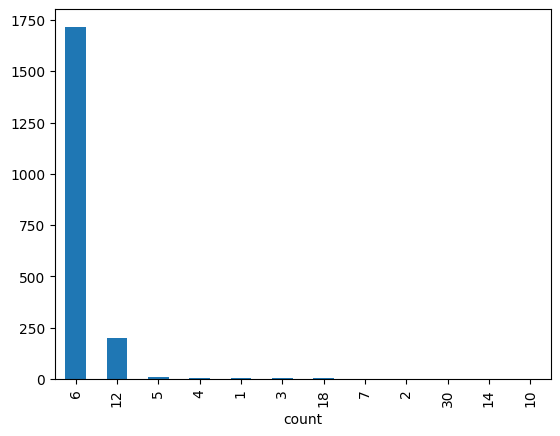

In [82]:
tf_metadata["gene_name_id"].value_counts().value_counts().plot(kind='bar')

In [83]:
len(tf_metadata["gene_name_id"].unique())

1951

In [84]:
# Find the guides where the same intended_target_name has multiple gene_name_id
tf_metadata[tf_metadata.groupby("intended_target_name")["gene_name_id"].transform("nunique") > 1]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene,in_tf_ref,in_nc_ref,is_OR_gene
1808,BHLHE40#chr3:4979339-4979357(-),AAGCCGAGGAGTAATGGAG,True,targeting,chr3,4979339.0,4979357.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GAAGCCGAGGAGTAATGGAG,BHLHE40,True,False,False
1809,BHLHE40#chr3:4979454-4979472(+),GGCGCAGACAGACCGCGCA,True,targeting,chr3,4979454.0,4979472.0,+,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GGGCGCAGACAGACCGCGCA,BHLHE40,True,False,False
1810,BHLHE40#chr3:4979487-4979505(-),GACTCAGCGCACAGACTGG,True,targeting,chr3,4979487.0,4979505.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GGACTCAGCGCACAGACTGG,BHLHE40,True,False,False
1811,BHLHE40#chr3:4979490-4979508(-),TCCGACTCAGCGCACAGAC,True,targeting,chr3,4979490.0,4979508.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GTCCGACTCAGCGCACAGAC,BHLHE40,True,False,False
1812,BHLHE40#chr3:4979495-4979513(+),TGCGCTGAGTCGGAGCCAG,True,targeting,chr3,4979495.0,4979513.0,+,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GTGCGCTGAGTCGGAGCCAG,BHLHE40,True,False,False
1813,BHLHE40#chr3:4979520-4979538(-),GCATGGCCCGGTGTCCCCG,True,targeting,chr3,4979520.0,4979538.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GGCATGGCCCGGTGTCCCCG,BHLHE40,True,False,False
8199,SCXA#chr8:144266603-144266621(-),AAGGACATGGGGCCGGCGG,True,targeting,chr8,144266603.0,144266621.0,-,NGG,ENSG00000260428,...,promoter,NaN,NaN,NaN,SCXA,GAAGGACATGGGGCCGGCGG,SCX,True,False,False
8200,SCXA#chr8:144266609-144266627(-),GTGGCGAAGGACATGGGGC,True,targeting,chr8,144266609.0,144266627.0,-,NGG,ENSG00000260428,...,promoter,NaN,NaN,NaN,SCXA,GGTGGCGAAGGACATGGGGC,SCX,True,False,False
8201,SCXA#chr8:144266615-144266633(-),CGCAGCGTGGCGAAGGACA,True,targeting,chr8,144266615.0,144266633.0,-,NGG,ENSG00000260428,...,promoter,NaN,NaN,NaN,SCXA,GCGCAGCGTGGCGAAGGACA,SCX,True,False,False
8202,SCXA#chr8:144266644-144266662(-),GGTACAGGTAGCGGCCCGG,True,targeting,chr8,144266644.0,144266662.0,-,NGG,ENSG00000260428,...,promoter,NaN,NaN,NaN,SCXA,GGGTACAGGTAGCGGCCCGG,SCX,True,False,False


In [85]:
tf_metadata[tf_metadata["intended_target_name"] == "ENSG00000134107"]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene,in_tf_ref,in_nc_ref,is_OR_gene
1808,BHLHE40#chr3:4979339-4979357(-),AAGCCGAGGAGTAATGGAG,True,targeting,chr3,4979339.0,4979357.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GAAGCCGAGGAGTAATGGAG,BHLHE40,True,False,False
1809,BHLHE40#chr3:4979454-4979472(+),GGCGCAGACAGACCGCGCA,True,targeting,chr3,4979454.0,4979472.0,+,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GGGCGCAGACAGACCGCGCA,BHLHE40,True,False,False
1810,BHLHE40#chr3:4979487-4979505(-),GACTCAGCGCACAGACTGG,True,targeting,chr3,4979487.0,4979505.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GGACTCAGCGCACAGACTGG,BHLHE40,True,False,False
1811,BHLHE40#chr3:4979490-4979508(-),TCCGACTCAGCGCACAGAC,True,targeting,chr3,4979490.0,4979508.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GTCCGACTCAGCGCACAGAC,BHLHE40,True,False,False
1812,BHLHE40#chr3:4979495-4979513(+),TGCGCTGAGTCGGAGCCAG,True,targeting,chr3,4979495.0,4979513.0,+,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GTGCGCTGAGTCGGAGCCAG,BHLHE40,True,False,False
1813,BHLHE40#chr3:4979520-4979538(-),GCATGGCCCGGTGTCCCCG,True,targeting,chr3,4979520.0,4979538.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,BHLHE40,GGCATGGCCCGGTGTCCCCG,BHLHE40,True,False,False
8923,STRA13#chr17:82022460-82022478(-),GAGATGAGGCCCCAGGACG,True,targeting,chr17,82022460.0,82022478.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,STRA13,GGAGATGAGGCCCCAGGACG,BHLHE40,True,False,False
8924,STRA13#chr17:82022644-82022662(+),GCGAGACACCAGCCCACGA,True,targeting,chr17,82022644.0,82022662.0,+,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,STRA13,GGCGAGACACCAGCCCACGA,BHLHE40,True,False,False
8925,STRA13#chr17:82022814-82022832(-),CCGGAAGGTGAGGGCCGGA,True,targeting,chr17,82022814.0,82022832.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,STRA13,GCCGGAAGGTGAGGGCCGGA,BHLHE40,True,False,False
8926,STRA13#chr17:82022823-82022841(-),ATCCGGCTTCCGGAAGGTG,True,targeting,chr17,82022823.0,82022841.0,-,NGG,ENSG00000134107,...,promoter,NaN,NaN,NaN,STRA13,GATCCGGCTTCCGGAAGGTG,BHLHE40,True,False,False


In [86]:
# Write out as fasta file
path_out_tf_fasta = "/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/tf_guides.fasta"
with open(path_out_tf_fasta, "w") as f:
    for _, row in tf_metadata.iterrows():
        f.write(f">{row['guide_id']}\n{row['spacer']}NGG\n")
print(f"Wrote TF guides to {path_out_tf_fasta}")

Wrote TF guides to /cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/tf_guides.fasta


In [87]:
blat_res = pd.read_csv("/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/2025_12_10_tf_guides_BLAT_res_v2.tsv", sep="\t")
blat_res["tEnd_adj"] = np.where(blat_res["strand"] == "+", blat_res["tEnd"] - 3, blat_res["tEnd"])
blat_res["tStart_adj"] = np.where(blat_res["strand"] == "+", blat_res["tStart"], blat_res["tStart"] + 3) + 1
blat_res["tStrand"] = blat_res["strand"]
blat_res["gene_name"] = blat_res["query"].str.split("#").str[0]
blat_res

,query,score,qStart,qEnd,qSize,identity,chrom,strand,tStart,tEnd,span,tEnd_adj,tStart_adj,tStrand,gene_name
0,AATF#chr17:36948966-36948984(+),21,1,22,22,100.0%,chr17,+,36948965,36948987,22,36948984,36948966,+,AATF
1,AATF#chr17:36949013-36949031(+),21,1,22,22,100.0%,chr17,+,36949012,36949034,22,36949031,36949013,+,AATF
2,AATF#chr17:36949020-36949038(+),21,1,22,22,100.0%,chr17,+,36949019,36949041,22,36949038,36949020,+,AATF
3,AATF#chr17:36949026-36949044(+),21,1,22,22,100.0%,chr17,+,36949025,36949047,22,36949044,36949026,+,AATF
4,AATF#chr17:36949031-36949049(+),21,1,22,22,100.0%,chr17,+,36949030,36949052,22,36949049,36949031,+,AATF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13366,ZZZ3#chr1:77682544-77682562(+),21,1,22,22,100.0%,chr1,+,77682543,77682565,22,77682562,77682544,+,ZZZ3
13367,ZZZ3#chr1:77682717-77682735(+),21,1,22,22,100.0%,chr1,+,77682716,77682738,22,77682735,77682717,+,ZZZ3
13368,ZZZ3#chr1:77683038-77683056(-),21,1,22,22,100.0%,chr1,-,77683034,77683056,22,77683056,77683038,-,ZZZ3
13369,ZZZ3#chr1:77683358-77683376(+),21,1,22,22,100.0%,chr1,+,77683357,77683379,22,77683376,77683358,+,ZZZ3


<Axes: xlabel='count'>

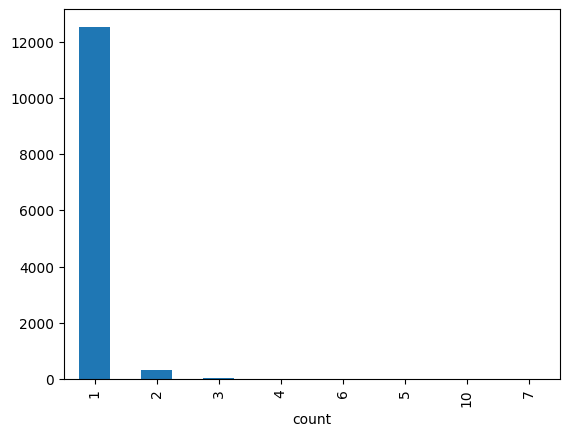

In [88]:
# how many query's with multiple alignments?
blat_res["query"].value_counts().value_counts().plot(kind="bar")

In [89]:
# How many that have 2 alignments are overlapping?
two_alignment_res = blat_res.groupby("query").filter(lambda x: len(x) == 2)
overlapping = []
for _, group in two_alignment_res.groupby("query"):
    pair_1 = (group.iloc[0]["tStart_adj"], group.iloc[0]["tEnd_adj"])
    pair_2 = (group.iloc[1]["tStart_adj"], group.iloc[1]["tEnd_adj"])
    if max(pair_1) > min(pair_2) and max(pair_2) > min(pair_1):
        overlapping.append(group.iloc[0]["query"])
len(two_alignment_res), len(overlapping)

(658, 0)

In [90]:
# First calculate how far the hit is from the TSS of the gene_name based on the gtf, use -1 if on a different chromosome
distances_from_intended_target = []
for _, row in tqdm(blat_res.iterrows()):
    target_promoter = promoters_df[(promoters_df["gene_name"] == row["gene_name"]) & (promoters_df["Chromosome"] == row["chrom"])]
    if not target_promoter.empty:
        dist = min(
            abs(row["tStart_adj"] - target_promoter["Start"].values[0]),
            abs(row["tStart_adj"] - target_promoter["End"].values[0]),
            abs(row["tEnd_adj"] - target_promoter["Start"].values[0]),
            abs(row["tEnd_adj"] - target_promoter["End"].values[0])
        )
        distances_from_intended_target.append(dist)
    else:
        distances_from_intended_target.append(-1)
blat_res["distance_from_intended_target"] = distances_from_intended_target
blat_res

13371it [00:35, 378.96it/s]


,query,score,qStart,qEnd,qSize,identity,chrom,strand,tStart,tEnd,span,tEnd_adj,tStart_adj,tStrand,gene_name,distance_from_intended_target
0,AATF#chr17:36948966-36948984(+),21,1,22,22,100.0%,chr17,+,36948965,36948987,22,36948984,36948966,+,AATF,42
1,AATF#chr17:36949013-36949031(+),21,1,22,22,100.0%,chr17,+,36949012,36949034,22,36949031,36949013,+,AATF,89
2,AATF#chr17:36949020-36949038(+),21,1,22,22,100.0%,chr17,+,36949019,36949041,22,36949038,36949020,+,AATF,96
3,AATF#chr17:36949026-36949044(+),21,1,22,22,100.0%,chr17,+,36949025,36949047,22,36949044,36949026,+,AATF,102
4,AATF#chr17:36949031-36949049(+),21,1,22,22,100.0%,chr17,+,36949030,36949052,22,36949049,36949031,+,AATF,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13366,ZZZ3#chr1:77682544-77682562(+),21,1,22,22,100.0%,chr1,+,77682543,77682565,22,77682562,77682544,+,ZZZ3,857
13367,ZZZ3#chr1:77682717-77682735(+),21,1,22,22,100.0%,chr1,+,77682716,77682738,22,77682735,77682717,+,ZZZ3,684
13368,ZZZ3#chr1:77683038-77683056(-),21,1,22,22,100.0%,chr1,-,77683034,77683056,22,77683056,77683038,-,ZZZ3,363
13369,ZZZ3#chr1:77683358-77683376(+),21,1,22,22,100.0%,chr1,+,77683357,77683379,22,77683376,77683358,+,ZZZ3,43


In [91]:
# find all gene promoters withing 100kb of each guide mapping
dist = 50_000
blat_res_pr = pr.PyRanges(blat_res[["query", "chrom", "tStart_adj", "tEnd_adj", "tStrand", "score", "gene_name", "distance_from_intended_target"]].rename(columns={"chrom": "Chromosome", "tStart_adj": "Start", "tEnd_adj": "End", "tStrand": "Strand"}))

# Find all gene promoters within 10kb of each guide mapping
overlaps_df = blat_res_pr.join(promoters_pr, how="left", slack=dist).df

# Pull out all those where gene_name matches gene_name_b in the overlap
overlap_matches = overlaps_df[overlaps_df["gene_name"] == overlaps_df["gene_name_b"]]
overlap_mismatches = overlaps_df[overlaps_df["gene_name"] != overlaps_df["gene_name_b"]]

In [92]:
# How many queries have 0 alignments where there is a match of gene_name and gene_name_b?
all_queries = set(overlaps_df["query"])
queries_wout_gene_matches = all_queries - set(overlap_matches["query"])
print(f"{len(queries_wout_gene_matches)} queries have 0 alignments where there is a match of gene_name and gene_name_b")

831 queries have 0 alignments where there is a match of gene_name and gene_name_b


In [93]:
queries_wout_gene_matches

{'AFF3#chr2:100142311-100142329(+)',
 'AFF3#chr2:100142359-100142377(+)',
 'AFF3#chr2:100142402-100142420(+)',
 'AHR#chr7:17298669-17298687(-)',
 'AHR#chr7:17298686-17298704(-)',
 'AHR#chr7:17298697-17298715(-)',
 'AHR#chr7:17298699-17298717(+)',
 'AHR#chr7:17298718-17298736(+)',
 'AHR#chr7:17298882-17298900(-)',
 'APITD1#chr1:10430503-10430521(+)',
 'APITD1#chr1:10430724-10430742(+)',
 'APITD1#chr1:10430743-10430761(+)',
 'APITD1#chr1:10430776-10430794(+)',
 'APITD1#chr1:10430787-10430805(+)',
 'APITD1#chr1:10430988-10431006(-)',
 'ARHGAP35#chr19:46918664-46918682(+)',
 'ARHGAP35#chr19:46918712-46918730(-)',
 'ARHGAP35#chr19:46918723-46918741(+)',
 'ARHGAP35#chr19:46918733-46918751(+)',
 'ARHGAP35#chr19:46918798-46918816(-)',
 'ARHGAP35#chr19:46918849-46918867(+)',
 'ARNTL#chr11:13277791-13277809(+)',
 'ARNTL#chr11:13277812-13277830(+)',
 'ARNTL#chr11:13277815-13277833(+)',
 'ARNTL#chr11:13277842-13277860(-)',
 'ARNTL#chr11:13277874-13277892(-)',
 'ARNTL#chr11:13277877-13277895(-)',
 

In [94]:
promoters_df[promoters_df["gene_name"] == "HKR1"]

,Chromosome,Strand,gene_id,gene_name,Start,End


In [95]:
guide_metadata[guide_metadata["guide_id"] == "T#chr6:166167825-166167843(+)"]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,intended_target_start,intended_target_end,label,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene
8971,T#chr6:166167825-166167843(+),CCCAAGGCTCTACTAGTGT,True,targeting,chr6,166167825.0,166167843.0,+,NGG,ENSG00000164458,...,166167825.0,166168669.0,targeting,promoter,NaN,NaN,NaN,T,GCCCAAGGCTCTACTAGTGT,TBXT


In [96]:
guide_metadata[guide_metadata["guide_id"] == "SUB1#chr5:32585577-32585595(+)"]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,intended_target_start,intended_target_end,label,genomic_element,putative_target_genes,reporter,imperfect,gene_name_id,G#spacer,gene_name_mygene
8941,SUB1#chr5:32585577-32585595(+),CGCGAGCGAACGACCAAGA,True,targeting,chr5,32585577.0,32585595.0,+,NGG,ENSG00000113387,...,32585577.0,32585974.0,targeting,promoter,NaN,NaN,NaN,SUB1,GCGCGAGCGAACGACCAAGA,SUB1


In [97]:
overlaps_df[overlaps_df["query"] == "TCEB1#chr8:73972068-73972086(-)"]

,query,Chromosome,Start,End,Strand,score,gene_name,distance_from_intended_target,Strand_b,gene_id,gene_name_b,Start_b,End_b
19594,TCEB1#chr8:73972068-73972086(-),chr8,73972068,73972086,-,21,TCEB1,-1,+,ENSG00000175606.11,TMEM70,73970436,73972436
19595,TCEB1#chr8:73972068-73972086(-),chr8,73972068,73972086,-,21,TCEB1,-1,-,ENSG00000154582.18,ELOC,73972307,73974307
19596,TCEB1#chr8:73972068-73972086(-),chr8,73972068,73972086,-,21,TCEB1,-1,+,ENSG00000154589.7,LY96,73989391,73991391


In [98]:
# for matches, take the on and only one that is closest to the TSS of the gene_name
best_overlap_matches = overlap_matches.groupby("query").apply(lambda x: x.loc[x["distance_from_intended_target"].idxmin()])
best_overlap_matches["blat_alignment_near_intended_target"] = True
assert best_overlap_matches["query"].nunique() == len(best_overlap_matches)

# for mismatches first only grab the ones that didn't have any match, then take the one closest to the TSS of the gene_name if it is not -1, then take the highest scoring
best_overlap_mismatches = []
for query in queries_wout_gene_matches:
    mismatches = overlap_mismatches[overlap_mismatches["query"] == query]
    if not mismatches.empty:
        closest_to_tss = mismatches.loc[mismatches["distance_from_intended_target"].idxmin()]
        if closest_to_tss["distance_from_intended_target"] != -1:
            best_overlap_mismatches.append(closest_to_tss)
        else:
            best_overlap_mismatches.append(mismatches.loc[mismatches["score"].idxmax()])
best_overlap_mismatches = pd.DataFrame(best_overlap_mismatches)
best_overlap_mismatches["blat_alignment_near_intended_target"] = False
assert best_overlap_mismatches["query"].nunique() == len(best_overlap_mismatches)

# Concat the best matches and mismatches
best_overlaps = pd.concat([best_overlap_matches, best_overlap_mismatches], ignore_index=True)
assert best_overlaps["query"].nunique() == len(best_overlaps)
(best_overlaps["gene_name"] == best_overlaps["gene_name_b"]).value_counts()

/tmp/ipykernel_1377720/3653042622.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_overlap_matches = overlap_matches.groupby("query").apply(lambda x: x.loc[x["distance_from_intended_target"].idxmin()])


True     12070
False      831
Name: count, dtype: int64

In [99]:
# Add in guide_chr, guide_start, guide_end from blat res to tf_metadata
tf_metadata = tf_metadata.merge(
    best_overlaps[["query", "Chromosome", "Start", "End", "Strand", "blat_alignment_near_intended_target"]],
    left_on="guide_id",
    right_on="query",
    how="left"
).rename(columns={
    "Chromosome": "guide_chr_blat",
    "Start": "guide_start_blat",
    "End": "guide_end_blat",
    "Strand": "strand_blat"
}).drop(columns=["query"])
tf_metadata[["guide_id", "spacer", "gene_name_id", "intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end", "guide_start", "guide_end", "guide_chr_blat", "guide_start_blat", "guide_end_blat"]]

,guide_id,spacer,gene_name_id,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,guide_start,guide_end,guide_chr_blat,guide_start_blat,guide_end_blat
0,AATF#chr17:36948966-36948984(+),AGTGGCCGGTCCAGAGCTG,AATF,ENSG00000276072,chr17,36948966.0,36949088.0,36948966.0,36948984.0,chr17,36948966.0,36948984.0
1,AATF#chr17:36949013-36949031(+),GAGTCGGGGAATCGGATCA,AATF,ENSG00000276072,chr17,36948966.0,36949088.0,36949013.0,36949031.0,chr17,36949013.0,36949031.0
2,AATF#chr17:36949020-36949038(+),GGAATCGGATCAAGGCGAG,AATF,ENSG00000276072,chr17,36948966.0,36949088.0,36949020.0,36949038.0,chr17,36949020.0,36949038.0
3,AATF#chr17:36949026-36949044(+),GGATCAAGGCGAGAGGATC,AATF,ENSG00000276072,chr17,36948966.0,36949088.0,36949026.0,36949044.0,chr17,36949026.0,36949044.0
4,AATF#chr17:36949031-36949049(+),AAGGCGAGAGGATCCGGCA,AATF,ENSG00000276072,chr17,36948966.0,36949088.0,36949031.0,36949049.0,chr17,36949031.0,36949049.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12929,ZZZ3#chr1:77682544-77682562(+),ACCAAGAGGCACTCGCCCC,ZZZ3,ENSG00000036549,chr1,77682531.0,77683403.0,77682544.0,77682562.0,chr1,77682544.0,77682562.0
12930,ZZZ3#chr1:77682717-77682735(+),TCCACTAGACCCAACATGG,ZZZ3,ENSG00000036549,chr1,77682531.0,77683403.0,77682717.0,77682735.0,chr1,77682717.0,77682735.0
12931,ZZZ3#chr1:77683038-77683056(-),TGTGCGCGGGCGAAAGGGG,ZZZ3,ENSG00000036549,chr1,77682531.0,77683403.0,77683038.0,77683056.0,chr1,77683038.0,77683056.0
12932,ZZZ3#chr1:77683358-77683376(+),GCTGCAGGAAGCTCGATAG,ZZZ3,ENSG00000036549,chr1,77682531.0,77683403.0,77683358.0,77683376.0,chr1,77683358.0,77683376.0


In [100]:
# Create a dictionary mapping query to number_of_blat_alignments
query_to_blat_alignments = blat_res["query"].value_counts().to_dict()

# Add number_of_blat_alignments to tf_metadata
tf_metadata["number_of_blat_alignments"] = tf_metadata["guide_id"].map(query_to_blat_alignments).fillna(0)
tf_metadata["number_of_blat_alignments"].value_counts()

number_of_blat_alignments
1.0     12519
2.0       329
3.0        36
0.0        33
4.0         9
5.0         3
6.0         3
10.0        1
7.0         1
Name: count, dtype: int64

In [101]:
print(f"Num missing guide_start_blat: {tf_metadata['guide_start_blat'].isna().sum()}")
tf_metadata[tf_metadata["guide_start_blat"].isna()]["gene_name_id"].value_counts()

Num missing guide_start_blat: 33


gene_name_id
AHDC1      1
BCL3       1
BCL6       1
CC2D1A     1
E2F5       1
EP300      1
FEV        1
GATAD2B    1
GRHL2      1
HOXB7      1
HOXB9      1
HOXC13     1
HOXC5      1
ING1       1
LMO4       1
PHF21A     1
RBL2       1
RCOR1      1
SMAD3      1
SOX1       1
TAF5L      1
TGIF1      1
THAP5      1
ZBTB33     1
ZNF281     1
ZNF284     1
ZNF365     1
ZNF385C    1
ZNF45      1
ZNF490     1
ZNF540     1
ZNF74      1
ZNF853     1
Name: count, dtype: int64

In [102]:
tf_metadata[tf_metadata["guide_start_blat"].isna()]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,gene_name_mygene,in_tf_ref,in_nc_ref,is_OR_gene,guide_chr_blat,guide_start_blat,guide_end_blat,strand_blat,blat_alignment_near_intended_target,number_of_blat_alignments
66,AHDC1#chr1:27604043-27604061(-),GCGGACCAGACAGACAGAC,True,targeting,chr1,27604043.0,27604061.0,-,NGG,ENSG00000126705,...,AHDC1,True,False,False,NaN,NaN,NaN,NaN,NaN,0.0
510,BCL3#chr19:44748690-44748708(-),TGCAGCCGGCTGAACTGAA,True,targeting,chr19,44748690.0,44748708.0,-,NGG,ENSG00000069399,...,BCL3,True,False,False,NaN,NaN,NaN,NaN,NaN,0.0
518,BCL6#chr3:187745392-187745410(+),AGCAACAGCAATAATCACC,True,targeting,chr3,187745392.0,187745410.0,+,NGG,ENSG00000113916,...,BCL6,True,False,False,NaN,NaN,NaN,NaN,NaN,0.0
758,CC2D1A#chr19:13906260-13906278(+),CGAGGCCCGAGGCGGAAGT,True,targeting,chr19,13906260.0,13906278.0,+,NGG,ENSG00000288293,...,CC2D1A,True,False,False,NaN,NaN,NaN,NaN,NaN,0.0
1549,E2F5#chr8:85177170-85177188(+),CCCCTCCCCCCTCGGTCGT,True,targeting,chr8,85177170.0,85177188.0,+,NGG,ENSG00000133740,...,E2F5,True,False,False,NaN,NaN,NaN,NaN,NaN,0.0
1752,EP300#chr22:41091729-41091747(-),TACAGGCTAGCGGTAGCGG,True,targeting,chr22,41091729.0,41091747.0,-,NGG,ENSG00000100393,...,EP300,True,False,False,NaN,NaN,NaN,NaN,NaN,0.0
2007,FEV#chr2:218984882-218984900(-),GAGGGCCGATTGTAATGTA,True,targeting,chr2,218984882.0,218984900.0,-,NGG,ENSG00000163497,...,FEV,True,False,False,NaN,NaN,NaN,NaN,NaN,0.0
2486,GATAD2B#chr1:153922735-153922753(-),GAGTTACACCGCCACCGCC,True,targeting,chr1,153922735.0,153922753.0,-,NGG,ENSG00000261992,...,GATAD2B,True,False,False,NaN,NaN,NaN,NaN,NaN,0.0
2642,GRHL2#chr8:101492605-101492623(+),GAGCGAGCGAGAGTGGTGA,True,targeting,chr8,101492605.0,101492623.0,+,NGG,ENSG00000083307,...,GRHL2,True,False,False,NaN,NaN,NaN,NaN,NaN,0.0
3325,HOXB7#chr17:48610567-48610585(-),GAGCAGAGGGACTCGGACT,True,targeting,chr17,48610567.0,48610585.0,-,NGG,ENSG00000260027,...,HOXB7,True,False,False,NaN,NaN,NaN,NaN,NaN,0.0


In [103]:
tf_metadata[tf_metadata["guide_start_blat"].isna()]["in_tf_ref"].value_counts()

in_tf_ref
True    33
Name: count, dtype: int64

In [104]:
# How many of those that already had coordinates match the blat coordinates
tf_metadata_had_coords = tf_metadata[~tf_metadata["guide_start"].isna()]
tf_metadata_had_coords[tf_metadata_had_coords["guide_start"] == tf_metadata_had_coords["guide_start_blat"]]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,gene_name_mygene,in_tf_ref,in_nc_ref,is_OR_gene,guide_chr_blat,guide_start_blat,guide_end_blat,strand_blat,blat_alignment_near_intended_target,number_of_blat_alignments
0,AATF#chr17:36948966-36948984(+),AGTGGCCGGTCCAGAGCTG,True,targeting,chr17,36948966.0,36948984.0,+,NGG,ENSG00000276072,...,AATF,True,False,False,chr17,36948966.0,36948984.0,+,True,1.0
1,AATF#chr17:36949013-36949031(+),GAGTCGGGGAATCGGATCA,True,targeting,chr17,36949013.0,36949031.0,+,NGG,ENSG00000276072,...,AATF,True,False,False,chr17,36949013.0,36949031.0,+,True,1.0
2,AATF#chr17:36949020-36949038(+),GGAATCGGATCAAGGCGAG,True,targeting,chr17,36949020.0,36949038.0,+,NGG,ENSG00000276072,...,AATF,True,False,False,chr17,36949020.0,36949038.0,+,True,1.0
3,AATF#chr17:36949026-36949044(+),GGATCAAGGCGAGAGGATC,True,targeting,chr17,36949026.0,36949044.0,+,NGG,ENSG00000276072,...,AATF,True,False,False,chr17,36949026.0,36949044.0,+,True,1.0
4,AATF#chr17:36949031-36949049(+),AAGGCGAGAGGATCCGGCA,True,targeting,chr17,36949031.0,36949049.0,+,NGG,ENSG00000276072,...,AATF,True,False,False,chr17,36949031.0,36949049.0,+,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12929,ZZZ3#chr1:77682544-77682562(+),ACCAAGAGGCACTCGCCCC,True,targeting,chr1,77682544.0,77682562.0,+,NGG,ENSG00000036549,...,ZZZ3,True,False,False,chr1,77682544.0,77682562.0,+,True,1.0
12930,ZZZ3#chr1:77682717-77682735(+),TCCACTAGACCCAACATGG,True,targeting,chr1,77682717.0,77682735.0,+,NGG,ENSG00000036549,...,ZZZ3,True,False,False,chr1,77682717.0,77682735.0,+,True,1.0
12931,ZZZ3#chr1:77683038-77683056(-),TGTGCGCGGGCGAAAGGGG,True,targeting,chr1,77683038.0,77683056.0,-,NGG,ENSG00000036549,...,ZZZ3,True,False,False,chr1,77683038.0,77683056.0,-,True,1.0
12932,ZZZ3#chr1:77683358-77683376(+),GCTGCAGGAAGCTCGATAG,True,targeting,chr1,77683358.0,77683376.0,+,NGG,ENSG00000036549,...,ZZZ3,True,False,False,chr1,77683358.0,77683376.0,+,True,1.0


In [105]:
overlaps_df[overlaps_df['query'] == "ZNF83#chr19:52637134-52637152(-)"]

,query,Chromosome,Start,End,Strand,score,gene_name,distance_from_intended_target,Strand_b,gene_id,gene_name_b,Start_b,End_b
44341,ZNF83#chr19:52637134-52637152(-),chr19,52528897,52528914,+,20,ZNF83,161645,-,ENSG00000269349.1,ENSG00000269349,52512342,52514342
44342,ZNF83#chr19:52637134-52637152(-),chr19,52528897,52528914,+,20,ZNF83,161645,+,ENSG00000198482.14,ZNF808,52525651,52527651
44343,ZNF83#chr19:52637134-52637152(-),chr19,52528897,52528914,+,20,ZNF83,161645,+,ENSG00000167562.14,ZNF701,52553821,52555821
44344,ZNF83#chr19:52637134-52637152(-),chr19,52528897,52528914,+,20,ZNF83,161645,+,ENSG00000289102.1,ENSG00000289102,52556016,52558016
50267,ZNF83#chr19:52637134-52637152(-),chr19,52637134,52637152,-,21,ZNF83,53407,-,ENSG00000268886.1,ENSG00000268886,52585561,52587561
50268,ZNF83#chr19:52637134-52637152(-),chr19,52637134,52637152,-,21,ZNF83,53407,+,ENSG00000290721.1,ENSG00000290721,52586504,52588504
50269,ZNF83#chr19:52637134-52637152(-),chr19,52637134,52637152,-,21,ZNF83,53407,-,ENSG00000268970.1,ENSG00000268970,52598887,52600887
50270,ZNF83#chr19:52637134-52637152(-),chr19,52637134,52637152,-,21,ZNF83,53407,+,ENSG00000290073.1,ENSG00000290073,52599274,52601274
50271,ZNF83#chr19:52637134-52637152(-),chr19,52992104,52992122,-,20,ZNF83,299545,-,ENSG00000221874.4,ZNF816-ZNF321P,52962823,52964823
50272,ZNF83#chr19:52637134-52637152(-),chr19,52992104,52992122,-,20,ZNF83,299545,-,ENSG00000180257.14,ZNF816,52962911,52964911


In [106]:
# How many of those that already had coordinates don't match the blat coordinates
tf_metadata_had_coords[tf_metadata_had_coords["guide_start"] != tf_metadata_had_coords["guide_start_blat"]][["guide_id", "spacer", "guide_start", "guide_start_blat"]]

,guide_id,spacer,guide_start,guide_start_blat
66,AHDC1#chr1:27604043-27604061(-),GCGGACCAGACAGACAGAC,27604043.0,NaN
510,BCL3#chr19:44748690-44748708(-),TGCAGCCGGCTGAACTGAA,44748690.0,NaN
518,BCL6#chr3:187745392-187745410(+),AGCAACAGCAATAATCACC,187745392.0,NaN
758,CC2D1A#chr19:13906260-13906278(+),CGAGGCCCGAGGCGGAAGT,13906260.0,NaN
1549,E2F5#chr8:85177170-85177188(+),CCCCTCCCCCCTCGGTCGT,85177170.0,NaN
1752,EP300#chr22:41091729-41091747(-),TACAGGCTAGCGGTAGCGG,41091729.0,NaN
2007,FEV#chr2:218984882-218984900(-),GAGGGCCGATTGTAATGTA,218984882.0,NaN
2341,FOXP2#chr7:114414522-114414540(+),AGAACTGTGATTTCAATTA,114414522.0,33119902.0
2486,GATAD2B#chr1:153922735-153922753(-),GAGTTACACCGCCACCGCC,153922735.0,NaN
2642,GRHL2#chr8:101492605-101492623(+),GAGCGAGCGAGAGTGGTGA,101492605.0,NaN


In [107]:
tf_metadata[~tf_metadata["intended_target_name"].str.startswith("ENSG")]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,gene_name_mygene,in_tf_ref,in_nc_ref,is_OR_gene,guide_chr_blat,guide_start_blat,guide_end_blat,strand_blat,blat_alignment_near_intended_target,number_of_blat_alignments


In [108]:
# Add a "new_guide_chr", "new_guide_start", "new_guide_end", "new_strand" based on the blat results
# If the the old guide coordinates are not NaN and don't match the blat coordinates, we will use those
# Otherwise, we will use the blat coordinates
# Also add a true/false column "blat_did_not_match" to indicate if the blat coordinates did not match the old coordinates
tf_metadata["new_guide_chr"] = np.where(
    (tf_metadata["guide_start"].notna()) & (tf_metadata["guide_start"] != tf_metadata["guide_start_blat"]),
    tf_metadata["guide_chr"],
    tf_metadata["guide_chr_blat"]
)
tf_metadata["new_guide_start"] = np.where(
    (tf_metadata["guide_start"].notna()) & (tf_metadata["guide_start"] != tf_metadata["guide_start_blat"]),
    tf_metadata["guide_start"],
    tf_metadata["guide_start_blat"]
)
tf_metadata["new_guide_end"] = np.where(
    (tf_metadata["guide_start"].notna()) & (tf_metadata["guide_start"] != tf_metadata["guide_start_blat"]),
    tf_metadata["guide_end"],
    tf_metadata["guide_end_blat"]
)
tf_metadata["new_strand"] = np.where(
    (tf_metadata["guide_start"].notna()) & (tf_metadata["guide_start"] != tf_metadata["guide_start_blat"]),
    tf_metadata["strand"],
    tf_metadata["strand_blat"]
)
tf_metadata["blat_matched_original_coords"] = (tf_metadata["guide_start"] == tf_metadata["guide_start_blat"])
tf_metadata

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,guide_start_blat,guide_end_blat,strand_blat,blat_alignment_near_intended_target,number_of_blat_alignments,new_guide_chr,new_guide_start,new_guide_end,new_strand,blat_matched_original_coords
0,AATF#chr17:36948966-36948984(+),AGTGGCCGGTCCAGAGCTG,True,targeting,chr17,36948966.0,36948984.0,+,NGG,ENSG00000276072,...,36948966.0,36948984.0,+,True,1.0,chr17,36948966.0,36948984.0,+,True
1,AATF#chr17:36949013-36949031(+),GAGTCGGGGAATCGGATCA,True,targeting,chr17,36949013.0,36949031.0,+,NGG,ENSG00000276072,...,36949013.0,36949031.0,+,True,1.0,chr17,36949013.0,36949031.0,+,True
2,AATF#chr17:36949020-36949038(+),GGAATCGGATCAAGGCGAG,True,targeting,chr17,36949020.0,36949038.0,+,NGG,ENSG00000276072,...,36949020.0,36949038.0,+,True,1.0,chr17,36949020.0,36949038.0,+,True
3,AATF#chr17:36949026-36949044(+),GGATCAAGGCGAGAGGATC,True,targeting,chr17,36949026.0,36949044.0,+,NGG,ENSG00000276072,...,36949026.0,36949044.0,+,True,1.0,chr17,36949026.0,36949044.0,+,True
4,AATF#chr17:36949031-36949049(+),AAGGCGAGAGGATCCGGCA,True,targeting,chr17,36949031.0,36949049.0,+,NGG,ENSG00000276072,...,36949031.0,36949049.0,+,True,1.0,chr17,36949031.0,36949049.0,+,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12929,ZZZ3#chr1:77682544-77682562(+),ACCAAGAGGCACTCGCCCC,True,targeting,chr1,77682544.0,77682562.0,+,NGG,ENSG00000036549,...,77682544.0,77682562.0,+,True,1.0,chr1,77682544.0,77682562.0,+,True
12930,ZZZ3#chr1:77682717-77682735(+),TCCACTAGACCCAACATGG,True,targeting,chr1,77682717.0,77682735.0,+,NGG,ENSG00000036549,...,77682717.0,77682735.0,+,True,1.0,chr1,77682717.0,77682735.0,+,True
12931,ZZZ3#chr1:77683038-77683056(-),TGTGCGCGGGCGAAAGGGG,True,targeting,chr1,77683038.0,77683056.0,-,NGG,ENSG00000036549,...,77683038.0,77683056.0,-,True,1.0,chr1,77683038.0,77683056.0,-,True
12932,ZZZ3#chr1:77683358-77683376(+),GCTGCAGGAAGCTCGATAG,True,targeting,chr1,77683358.0,77683376.0,+,NGG,ENSG00000036549,...,77683358.0,77683376.0,+,True,1.0,chr1,77683358.0,77683376.0,+,True


In [109]:
# Create new to be "gene_name_id#guide_chr:guide_start-guide_end(guide_strand)", for those with non NaN blat results
tf_metadata["new_guide_id"] = tf_metadata.apply(
    lambda x: f"{x['gene_name_id']}#{x['new_guide_chr']}:{int(x['new_guide_start'])}-{int(x['new_guide_end'])}({x['new_strand']})"
    if pd.notna(x['new_guide_chr'])
    else x['guide_id'],
    axis=1
)

In [110]:
# clean up
tf_metadata["targeting"] = True
tf_metadata["pam"] = "NGG"
tf_metadata["label"] = "tf_targeting"
tf_metadata["type"] = "targeting"

# For blat_aligment_near_intended_target as NaN, set to False
tf_metadata["blat_alignment_near_intended_target"] = tf_metadata["blat_alignment_near_intended_target"].fillna(False)

# Since we have coords for all of them
tf_metadata["using_guide_coords_for_intended_target"] = False

# Replace T# with TBXT# at start only of new_guide_id
tf_metadata["new_guide_id"] = tf_metadata["new_guide_id"].str.replace("^T#", "TBXT#", regex=True)

# Clean
tf_clean_metadata = tf_metadata[["new_guide_id", "spacer", "targeting", "type",
             "new_guide_chr", "new_guide_start", "new_guide_end", "new_strand", "pam",
             "intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end",
             "gene_name_id", "label", "genomic_element", "putative_target_genes", "reporter", "imperfect",
             "number_of_blat_alignments", "blat_alignment_near_intended_target", "blat_matched_original_coords", "using_guide_coords_for_intended_target", "in_tf_ref"]].rename(columns={"new_guide_id": "guide_id", "gene_name_id": "gene_name", "new_guide_chr": "guide_chr", "new_guide_start": "guide_start", "new_guide_end": "guide_end", "new_strand": "strand", "in_tf_ref": "in_ref_spreadsheet"})

print(tf_clean_metadata["number_of_blat_alignments"].value_counts()),
print(tf_clean_metadata["blat_alignment_near_intended_target"].value_counts()), 
print(tf_clean_metadata["blat_matched_original_coords"].value_counts()),
print(tf_clean_metadata["using_guide_coords_for_intended_target"].value_counts()),
print(tf_clean_metadata["in_ref_spreadsheet"].value_counts())

number_of_blat_alignments
1.0     12519
2.0       329
3.0        36
0.0        33
4.0         9
5.0         3
6.0         3
10.0        1
7.0         1
Name: count, dtype: int64
blat_alignment_near_intended_target
True     12070
False      864
Name: count, dtype: int64
blat_matched_original_coords
True     12895
False       39
Name: count, dtype: int64
using_guide_coords_for_intended_target
False    12934
Name: count, dtype: int64
in_ref_spreadsheet
True    12934
Name: count, dtype: int64


/tmp/ipykernel_1377720/2404745186.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tf_metadata["blat_alignment_near_intended_target"] = tf_metadata["blat_alignment_near_intended_target"].fillna(False)


## Spacers that I couldn't find in ref

In [111]:
# Find any spacers that do not match
mismatched_spacers = targeting_metadata[(~targeting_metadata["in_tf_ref"]) & (~targeting_metadata["in_nc_ref"])]
mismatched_spacers[["intended_target_name", "gene_name_mygene", "spacer"]]

,intended_target_name,gene_name_mygene,spacer
61,ENSG00000291779,OR11H6,GCGTCGAGTTTCTCAGTAA
62,ENSG00000291779,OR11H6,TCTAAAACGATTGAGTACG
123,ENSG00000171501,OR1N2,TATTTAACTGACACATGGA
160,ENSG00000196242,OR2C3,CTAAAGACACTTTAAAGTC
161,ENSG00000196242,OR2C3,AGAGTGCTACCCAGAACGA
162,ENSG00000196242,OR2C3,CCCGTACTAGATTATGACT
163,ENSG00000196242,OR2C3,CGGTTTTTCTTAGAGTGCT
164,ENSG00000196242,OR2C3,GTTATTCTGGAGAGACCTT
165,ENSG00000196242,OR2C3,TAGATGTTAGGTCATTCCA
178,ENSG00000204688,OR2H1,AGGACCGTGACTGTGAGTA


In [112]:
mismatched_gene_name["intended_target_name"].isna().sum()

np.int64(0)

In [113]:
mismatched_spacers["gene_name_id"].value_counts()

gene_name_id
OR11H6-1    1
OR11H6-5    1
OR1N2-5     1
OR2C3-1     1
OR2C3-2     1
OR2C3-3     1
OR2C3-4     1
OR2C3-5     1
OR2C3-6     1
OR2H1-1     1
OR2W1-1     1
OR2W1-2     1
OR2W1-5     1
OR56A4-2    1
OR56A4-3    1
OR56A4-4    1
OR9Q1-1     1
OR9Q1-2     1
OR9Q1-3     1
OR9Q1-5     1
OR9Q1-6     1
Name: count, dtype: int64

# Make a final metadata table

In [151]:
print(f"Positive controls: {len(pc_clean_metadata)}, Non-targeting controls: {len(nt_clean_metadata)}, Negative controls: {len(nc_clean_metadata)}, Targeting guides: {len(tf_clean_metadata)}")
print(f"Total: {len(pc_clean_metadata) + len(nt_clean_metadata) + len(nc_clean_metadata) + len(tf_clean_metadata)}")

Positive controls: 19, Non-targeting controls: 600, Negative controls: 619, Targeting guides: 12934
Total: 14172


In [152]:
# Make final metadata
final_metadata = pd.concat([pc_clean_metadata, nt_clean_metadata, nc_clean_metadata, tf_clean_metadata], ignore_index=True)

# Make sure all coordinates are integers or NaN
cols = ["guide_start", "guide_end", "intended_target_start", "intended_target_end"]
for c in cols:
    final_metadata[c] = (
        pd.to_numeric(final_metadata[c], errors="coerce")  # convert to numeric, set invalid to NaN
        .astype("Int64")                                   # use pandas nullable int type
    )

In [153]:
# If intendend_target_name has .suffix, remove the suffix
final_metadata["intended_target_name"] = final_metadata["intended_target_name"].str.split(".").str[0]

In [154]:
# Check that guide_chr matches intended_target_chr
(final_metadata['guide_chr'] == final_metadata['intended_target_chr']).sum()

np.int64(13553)

In [155]:
final_metadata[(final_metadata['guide_chr'] != final_metadata['intended_target_chr'])]["label"].value_counts()

label
non_targeting       600
negative_control     19
Name: count, dtype: int64

In [156]:
final_metadata[(final_metadata['guide_chr'] != final_metadata['intended_target_chr'])]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,label,genomic_element,putative_target_genes,reporter,imperfect,in_ref_spreadsheet,number_of_blat_alignments,blat_alignment_near_intended_target,blat_matched_original_coords,using_guide_coords_for_intended_target
19,non-targeting_00006,TATGGAGGGCTGGATCTGC,False,non-targeting,NaN,<NA>,<NA>,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0.0,False,False,False
20,non-targeting_00010,TATCGGTCTGTACGGGTAG,False,non-targeting,NaN,<NA>,<NA>,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0.0,False,False,False
21,non-targeting_00013,AGAGGTCGGATACGCTTCC,False,non-targeting,NaN,<NA>,<NA>,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0.0,False,False,False
22,non-targeting_00018,GTCGCCGTAGGGTCCGCCA,False,non-targeting,NaN,<NA>,<NA>,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0.0,False,False,False
23,non-targeting_00020,AGCCTAACGATCGGACCGA,False,non-targeting,NaN,<NA>,<NA>,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,OR9Q1-1,ACGGTGTGTCTCTACCATC,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000186509,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
1228,OR9Q1-2,TCTACCATCTCCCTCGCTT,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000186509,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
1229,OR9Q1-3,GTGTCGATGCCGGACTGCC,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000186509,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
1230,OR9Q1-5,GATGCCGGACTGCCTCCAT,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000186509,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False


In [157]:
final_metadata[(final_metadata['guide_chr'] != final_metadata['intended_target_chr'])][-20:]

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,label,genomic_element,putative_target_genes,reporter,imperfect,in_ref_spreadsheet,number_of_blat_alignments,blat_alignment_near_intended_target,blat_matched_original_coords,using_guide_coords_for_intended_target
618,non-targeting_03783,GAGCTAGGATCGAACGACA,False,non-targeting,NaN,<NA>,<NA>,NaN,NaN,NaN,...,non_targeting,NaN,NaN,NaN,NaN,True,0.0,False,False,False
661,OR11H6-1,GCGTCGAGTTTCTCAGTAA,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000291779,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
662,OR11H6-5,TCTAAAACGATTGAGTACG,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000291779,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
760,OR2C3-1,CTAAAGACACTTTAAAGTC,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000196242,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
761,OR2C3-2,AGAGTGCTACCCAGAACGA,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000196242,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
762,OR2C3-3,CCCGTACTAGATTATGACT,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000196242,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
763,OR2C3-4,CGGTTTTTCTTAGAGTGCT,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000196242,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
764,OR2C3-5,GTTATTCTGGAGAGACCTT,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000196242,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
765,OR2C3-6,TAGATGTTAGGTCATTCCA,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000196242,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False
778,OR2H1-1,AGGACCGTGACTGTGAGTA,True,negative control,NaN,<NA>,<NA>,NaN,NGG,ENSG00000204688,...,negative_control,promoter,NaN,NaN,NaN,False,0.0,False,False,False


In [158]:
pd.crosstab(final_metadata['label'], final_metadata['number_of_blat_alignments'])


number_of_blat_alignments,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,10.0
label,,,,,,,,,
negative_control,20,505,64,20,6,2,2,0,0
non_targeting,600,0,0,0,0,0,0,0,0
positive_control,0,19,0,0,0,0,0,0,0
tf_targeting,33,12519,329,36,9,3,3,1,1


In [159]:
pd.crosstab(final_metadata['label'], final_metadata['blat_alignment_near_intended_target'])


blat_alignment_near_intended_target,False,True
label,,
negative_control,31,588
non_targeting,600,0
positive_control,0,19
tf_targeting,864,12070


In [160]:
pd.crosstab(final_metadata['label'], final_metadata['blat_matched_original_coords'])

blat_matched_original_coords,False,True
label,,
negative_control,128,491
non_targeting,600,0
positive_control,6,13
tf_targeting,39,12895


In [161]:
pd.crosstab(final_metadata['label'], final_metadata['using_guide_coords_for_intended_target'])

using_guide_coords_for_intended_target,False,True
label,,
negative_control,511,108
non_targeting,600,0
positive_control,13,6
tf_targeting,12934,0


In [162]:
pd.crosstab(final_metadata['label'], final_metadata['in_ref_spreadsheet'])

in_ref_spreadsheet,False,True
label,,
negative_control,21,598
non_targeting,0,600
positive_control,0,19
tf_targeting,0,12934


In [163]:
# guide_id	spacer	targeting	type	guide_chr	guide_start	guide_end	strand	pam	genomic_element	intended_target_name	intended_target_chr	intended_target_start	intended_target_end	putative_target_genes	reporter	imperfect	gene_name	label	using_guide_coords_for_intended_target	has_blat_alignment	blat_alignment_near_intended_target	blat_did_not_match_original_coords
col_order = [
    "guide_id", "spacer", "targeting", "type", "guide_chr", "guide_start", "guide_end", "strand", "pam",
    "genomic_element", "intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end",
    "putative_target_genes", "reporter", "imperfect", "gene_name", "label",
    "in_ref_spreadsheet", "number_of_blat_alignments", "blat_alignment_near_intended_target", "blat_matched_original_coords", "using_guide_coords_for_intended_target"
]

In [164]:
# For gene_name == "SMARCB1", make sure intended_target_name is "ENSG00000099956"
final_metadata.loc[final_metadata['gene_name'] == "SMARCB1", 'intended_target_name'] = "ENSG00000099956"

# For gene_name == "TCF7L1", make sure intended_target_name is "ENSG00000152284"
final_metadata.loc[final_metadata['gene_name'] == "TCF7L1", 'intended_target_name'] = "ENSG00000152284"

In [165]:
# For OR8U8 gene name, use the guide coords as intended target coords and update using_guide_coords_for_intended_target to True
final_metadata.loc[final_metadata['gene_name'] == "OR8U8", 'using_guide_coords_for_intended_target'] = True
final_metadata.loc[final_metadata['gene_name'] == "OR8U8", 'intended_target_chr'] = final_metadata.loc[final_metadata['gene_name'] == "OR8U8", 'guide_chr']
final_metadata.loc[final_metadata['gene_name'] == "OR8U8", 'intended_target_start'] = final_metadata.loc[final_metadata['gene_name'] == "OR8U8", 'guide_start']
final_metadata.loc[final_metadata['gene_name'] == "OR8U8", 'intended_target_end'] = final_metadata.loc[final_metadata['gene_name'] == "OR8U8", 'guide_end']
final_metadata.loc[final_metadata['gene_name'] == "OR8U8"][["gene_name", "intended_target_name", "intended_target_chr", "intended_target_start", "intended_target_end", "using_guide_coords_for_intended_target"]]

,gene_name,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,using_guide_coords_for_intended_target
1197,OR8U8,ENSG00000262315,chr11,56375606,56375624,True
1198,OR8U8,ENSG00000262315,chr11,56375627,56375645,True
1199,OR8U8,ENSG00000262315,chr11,56375674,56375692,True
1200,OR8U8,ENSG00000262315,chr11,56375683,56375701,True
1201,OR8U8,ENSG00000262315,chr11,56375720,56375738,True
1202,OR8U8,ENSG00000262315,chr11,56375907,56375925,True


In [166]:
final_metadata.loc[final_metadata['gene_name'].str.startswith("SCX").fillna(False)]

/tmp/ipykernel_1377720/3795401235.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_metadata.loc[final_metadata['gene_name'].str.startswith("SCX").fillna(False)]


,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,intended_target_name,...,label,genomic_element,putative_target_genes,reporter,imperfect,in_ref_spreadsheet,number_of_blat_alignments,blat_alignment_near_intended_target,blat_matched_original_coords,using_guide_coords_for_intended_target
8199,SCXA#chr8:144266603-144266621(-),AAGGACATGGGGCCGGCGG,True,targeting,chr8,144266603,144266621,-,NGG,ENSG00000260428,...,tf_targeting,promoter,NaN,NaN,NaN,True,1.0,False,True,False
8200,SCXA#chr8:144266609-144266627(-),GTGGCGAAGGACATGGGGC,True,targeting,chr8,144266609,144266627,-,NGG,ENSG00000260428,...,tf_targeting,promoter,NaN,NaN,NaN,True,1.0,False,True,False
8201,SCXA#chr8:144266615-144266633(-),CGCAGCGTGGCGAAGGACA,True,targeting,chr8,144266615,144266633,-,NGG,ENSG00000260428,...,tf_targeting,promoter,NaN,NaN,NaN,True,1.0,False,True,False
8202,SCXA#chr8:144266644-144266662(-),GGTACAGGTAGCGGCCCGG,True,targeting,chr8,144266644,144266662,-,NGG,ENSG00000260428,...,tf_targeting,promoter,NaN,NaN,NaN,True,1.0,False,True,False
8203,SCXA#chr8:144266652-144266670(-),CACCTCGGGGTACAGGTAG,True,targeting,chr8,144266652,144266670,-,NGG,ENSG00000260428,...,tf_targeting,promoter,NaN,NaN,NaN,True,1.0,False,True,False
8204,SCXB#chr8:144266662-144266680(+),CCCGAGGTGAGCCCGCTGT,True,targeting,chr8,144266662,144266680,+,NGG,ENSG00000260428,...,tf_targeting,promoter,NaN,NaN,NaN,True,1.0,False,True,False
8205,SCXB#chr8:144266665-144266683(+),GAGGTGAGCCCGCTGTCGG,True,targeting,chr8,144266665,144266683,+,NGG,ENSG00000260428,...,tf_targeting,promoter,NaN,NaN,NaN,True,1.0,False,True,False
8206,SCXB#chr8:144267049-144267067(+),GGGCCCGCCTTCTTCCACG,True,targeting,chr8,144267049,144267067,+,NGG,ENSG00000260428,...,tf_targeting,promoter,NaN,NaN,NaN,True,1.0,False,True,False
8207,SCXB#chr8:144267056-144267074(-),CGCGCCGCGTGGAAGAAGG,True,targeting,chr8,144267056,144267074,-,NGG,ENSG00000260428,...,tf_targeting,promoter,NaN,NaN,NaN,True,1.0,False,True,False
8208,SCXB#chr8:144267059-144267077(-),GCGCGCGCCGCGTGGAAGA,True,targeting,chr8,144267059,144267077,-,NGG,ENSG00000260428,...,tf_targeting,promoter,NaN,NaN,NaN,True,1.0,False,True,False


In [167]:
# For gene_name starting with SCX, add the gene_name as a suffix to intended_target_name
# So if gene_name is "SCXA", intended_target_name should be "{Current intended_target_name}#SCXA"
final_metadata.loc[final_metadata['gene_name'].str.startswith("SCX").fillna(False), 'intended_target_name'] = (
    final_metadata.loc[final_metadata['gene_name'].str.startswith("SCX").fillna(False), 'intended_target_name'] + "#" +
    final_metadata.loc[final_metadata['gene_name'].str.startswith("SCX").fillna(False), 'gene_name']
)
final_metadata.loc[final_metadata['gene_name'].str.startswith("SCX").fillna(False), 'intended_target_name']

/tmp/ipykernel_1377720/1629191401.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_metadata.loc[final_metadata['gene_name'].str.startswith("SCX").fillna(False), 'intended_target_name'] + "#" +
/tmp/ipykernel_1377720/1629191401.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_metadata.loc[final_metadata['gene_name'].str.startswith("SCX").fillna(False), 'gene_name']
/tmp/ipykernel_1377720/1629191401.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call resul

8199    ENSG00000260428#SCXA
8200    ENSG00000260428#SCXA
8201    ENSG00000260428#SCXA
8202    ENSG00000260428#SCXA
8203    ENSG00000260428#SCXA
8204    ENSG00000260428#SCXB
8205    ENSG00000260428#SCXB
8206    ENSG00000260428#SCXB
8207    ENSG00000260428#SCXB
8208    ENSG00000260428#SCXB
Name: intended_target_name, dtype: object

In [168]:
# For gene_names BHLHE40 and STRA13, same idea
final_metadata.loc[final_metadata['gene_name'] == "BHLHE40", 'intended_target_name'] = (
    final_metadata.loc[final_metadata['gene_name'] == "BHLHE40", 'intended_target_name'] + "#" +
    final_metadata.loc[final_metadata['gene_name'] == "BHLHE40", 'gene_name']
)
final_metadata.loc[final_metadata['gene_name'] == "STRA13", 'intended_target_name'] = (
    final_metadata.loc[final_metadata['gene_name'] == "STRA13", 'intended_target_name'] + "#" +
    final_metadata.loc[final_metadata['gene_name'] == "STRA13", 'gene_name']
)
final_metadata.loc[final_metadata['gene_name'].isin(["BHLHE40", "STRA13"]), 'intended_target_name']

1808    ENSG00000134107#BHLHE40
1809    ENSG00000134107#BHLHE40
1810    ENSG00000134107#BHLHE40
1811    ENSG00000134107#BHLHE40
1812    ENSG00000134107#BHLHE40
1813    ENSG00000134107#BHLHE40
8923     ENSG00000134107#STRA13
8924     ENSG00000134107#STRA13
8925     ENSG00000134107#STRA13
8926     ENSG00000134107#STRA13
8927     ENSG00000134107#STRA13
8928     ENSG00000134107#STRA13
Name: intended_target_name, dtype: object

In [ ]:
# Make CD81#chr11:2377315-2377333(+) with spacer GAGAGCGAGCGCGCAACGG --> CD81#chr11:2377315-2377333(+)#strong
# Make CD81#chr11:2377315-2377333(+) with spacer --> CD81#chr11:2377315-2377333(+)#weak
final_metadata.loc[
    (final_metadata['guide_id'] == "CD81#chr11:2377315-2377333(+)") & (final_metadata['spacer'] == "GAGAGCGAGCGCGCAACGG"),
    'guide_id'
] = "CD81#chr11:2377315-2377333(+)#strong"
final_metadata.loc[
    (final_metadata['guide_id'] == "CD81#chr11:2377315-2377333(+)") & (final_metadata['spacer'] != "GAGAGCGAGCGCGCAACGG"),
    'guide_id'
] = "CD81#chr11:2377315-2377333(+)#weak"

In [169]:
final_metadata[col_order].to_csv("/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/production_guide_metadata_full_v5.tsv", sep="\t", index=False)

In [170]:
# Drop all that have guide_chr == NaN and type != "non-targeting", also remove
# OR1N2#chrX:89996924-89996942(-)
# OR2W1#chr2:231842279-231842297(-)
final_metadata_filt = final_metadata[~((final_metadata["guide_chr"].isna()) & (final_metadata["type"] != "non-targeting"))]
final_metadata_filt = final_metadata_filt[~final_metadata_filt["guide_id"].isin(["OR1N2#chrX:89996924-89996942(-)", "OR2W1#chr2:231842279-231842297(-)"])]

In [171]:
# How many missing guides don't have any other guides with those intended targets?
# ALso add in OR1N2 and OR2W1
missing_targets = final_metadata[final_metadata["guide_chr"].isna()]["gene_name"].unique()
missing_targets = np.append(missing_targets, ["OR1N2", "OR2W1"])

# Which of missing targets are not in any of the gene_name's of final_metadata_filt
missing_targets = [t for t in missing_targets if t not in final_metadata_filt["gene_name"].unique()]
missing_targets

[nan]

In [172]:
# Check to see which ENS ids are found in the gtf file
gtf_ens_ids = gtf_pr[(gtf_pr.Feature == "gene")].df["gene_id"].str.split(".").str[0]

# 
final_metadata_filt["ens_id_in_gtf"] = final_metadata_filt["intended_target_name"].isin(gtf_ens_ids)

In [173]:
col_order = col_order + ["ens_id_in_gtf"]

In [174]:
final_metadata_filt[col_order].to_csv("/cellar/users/aklie/data/datasets/tf_perturb_seq/scratch/2025_12_10/production_guide_metadata_v5.tsv", sep="\t", index=False)

# DONE!

---